In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 1
!hostname
!pwd

dv001.ib.bridges2.psc.edu
/ocean/projects/asc170022p/mtragoza/mre-pinn/IPMI-2023


In [2]:
import sys, os, pathlib
import numpy as np
import xarray as xr
import torch
import matplotlib.pyplot as plt
import seaborn as sns

os.environ['DDEBACKEND'] = 'pytorch'
import deepxde

sys.path.append('..')
%aimport mre_pinn

torch.cuda.is_available()

Using backend: pytorch



True

In [ ]:
%autoreload
bioqic = mre_pinn.data.BIOQICFEMBox('../data/BIOQIC/downloads')
bioqic.download()
bioqic.load_mat()
bioqic.preprocess()
dataset = bioqic.to_dataset()
dataset.save_xarrays('../data/BIOQIC/fem_box')

Loading ../data/BIOQIC/fem_box/60/wave.nc
Loading ../data/BIOQIC/fem_box/60/mre.nc
Loading ../data/BIOQIC/fem_box/60/mre_mask.nc


<IPython.core.display.Javascript object>


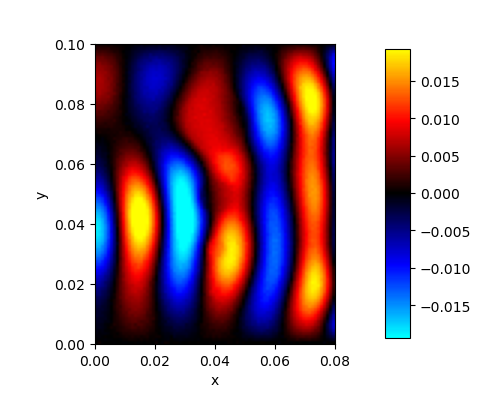

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

In [3]:
%autoreload
example = mre_pinn.data.MREExample.load_xarrays('../data/BIOQIC/fem_box', 60)
example.add_gaussian_noise(0.001)
example.view('wave', ax_height=3)

In [4]:
example.metadata

size  spacing  origin  limit  center  extent
variable dimension                                              
wave     x            80    0.001     0.0  0.079  0.0395    0.08
         y           100    0.001     0.0  0.099  0.0495    0.10
         z            10    0.001     0.0  0.009  0.0045    0.01
mre      x            80    0.001     0.0  0.079  0.0395    0.08
         y           100    0.001     0.0  0.099  0.0495    0.10
         z            10    0.001     0.0  0.009  0.0045    0.01
mre_mask x            80    0.001     0.0  0.079  0.0395    0.08
         y           100    0.001     0.0  0.099  0.0495    0.10
         z            10    0.001     0.0  0.009  0.0045    0.01

In [5]:
example.describe()

dtype    count                     mean          std  \
variable component                                                              
wave     y          complex128  80000.0  -0.00000100-0.00001100j     0.000759   
         x          complex128  80000.0   0.00022200-0.00020700j     0.000777   
         z          complex128  80000.0   0.00092400+0.00006000j     0.012494   
mre      scalar     complex128  80000.0  3382.375000+376.991118j  1590.727619   
mre_mask scalar          int64  80000.0   1.07650000+0.00000000j     0.362143   

                                        min                      25%  \
variable component                                                     
wave     y          -0.00223600-0.00071300j  -0.00032600+0.00012900j   
         x          -0.00304800+0.00029600j  -0.00010500+0.00000900j   
         z          -0.02344000-0.00261500j  -0.00443300-0.00672500j   
mre      scalar     3000.000000+376.991118j  3000.000000+376.991118j   
mre_mask scalar      1.00000000+0.00000000j   1.00000000+0.00000000j   

                                        50%                      75%  \
variable component                                                     
wave     y           0.00002100+0.00006400j   0.00033200+0.00013700j   
         x           0.00019200+0.00021500j   0.00055900+0.00025500j   
         z           0.00069400+0.00228200j   0.00688600+0.00220900j   
mre      scalar     3000.000000+376.991118j  3000.000000+376.991118j   
mre_mask scalar      1.00000000+0.00000000j   1.00000000+0.00000000j   

                                         max  
variable component                            
wave     y          0.002076000+0.000623000j  
         x          0.003038000-0.001667000j  
         z          0.023007000+0.003732000j  
mre      scalar     10000.000000+376.991118j  
mre_mask scalar     5.000000000+0.000000000j

Evaluating direct baseline
Evaluating FEM baseline
100%|██████████| 10/10 [00:11<00:00,  1.17s/it]


<IPython.core.display.Javascript object>


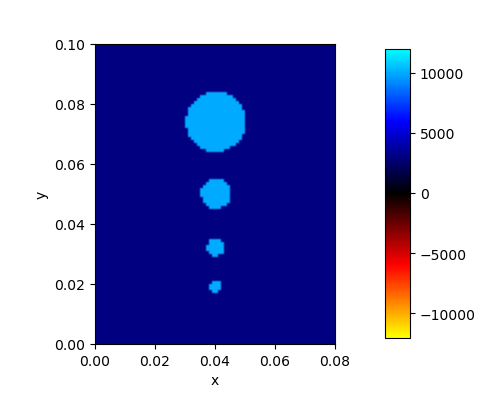

interactive(children=(SelectionSlider(description='part', options=(('abs', 0), ('angle', 1)), value=0), Select…

<IPython.core.display.Javascript object>


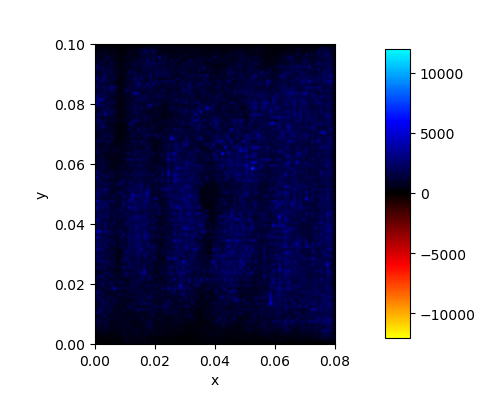

interactive(children=(SelectionSlider(description='part', options=(('abs', 0), ('angle', 1)), value=0), Select…

<IPython.core.display.Javascript object>


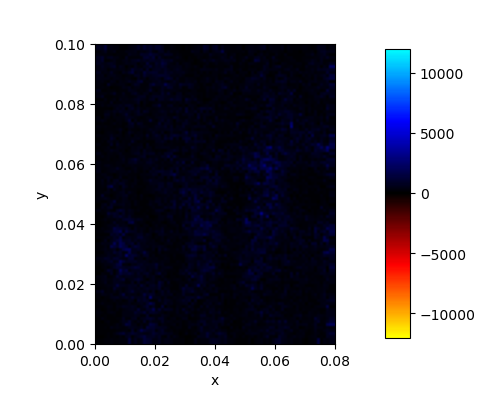

interactive(children=(SelectionSlider(description='part', options=(('abs', 0), ('angle', 1)), value=0), Select…

In [8]:
%autoreload
frequency = example.wave.frequency.item()
mre_pinn.baseline.eval_direct_baseline(example, frequency=frequency)
mre_pinn.baseline.eval_fem_baseline(example, frequency=frequency)
example.view('mre', 'direct', 'fem', ax_height=3, polar=True, vmax=12e3)

In [9]:
pde = mre_pinn.pde.WaveEquation.from_name('hetero', omega=frequency, detach=True)

In [37]:
%autoreload
pinn = mre_pinn.model.MREPINN(
    example,
    omega=30,
    n_layers=5,
    n_hidden=128,
    polar_input=False,
    conditional=False
)
pinn

MREPINN(
  (u_pinn): PINN(
    (hidden0): Linear(in_features=3, out_features=128, bias=True)
    (hidden1): Linear(in_features=131, out_features=128, bias=True)
    (hidden2): Linear(in_features=259, out_features=128, bias=True)
    (hidden3): Linear(in_features=387, out_features=128, bias=True)
    (output): Linear(in_features=515, out_features=6, bias=True)
  )
  (mu_pinn): PINN(
    (hidden0): Linear(in_features=3, out_features=128, bias=True)
    (hidden1): Linear(in_features=131, out_features=128, bias=True)
    (hidden2): Linear(in_features=259, out_features=128, bias=True)
    (hidden3): Linear(in_features=387, out_features=128, bias=True)
    (output): Linear(in_features=515, out_features=2, bias=True)
  )
)

In [38]:
%autoreload
model = mre_pinn.training.MREPINNModel(
    example, pinn, pde,
    loss_weights=[1, 0, 1e-6],
    pde_warmup_iters=5000,
    pde_step_iters=5000,
    pde_init_weight=1e-10,
    n_points=1024
)
model.compile(optimizer='adam', lr=1e-4, loss=mre_pinn.training.losses.msae_loss)

Compiling model...
'compile' took 0.000217 s



In [39]:
%autoreload
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = False
model.benchmark(100)

# iterations: 100
Data time/iter:  0.0018s (3.04%)
Model time/iter: 0.0007s (1.16%)
Loss time/iter:  0.0553s (95.80%)
Total time/iter: 0.0577s
Total time: 5.7746s
1k iters time: 0.96m
10k iters time: 9.62m
100k iters time: 1.60h


<IPython.core.display.Javascript object>


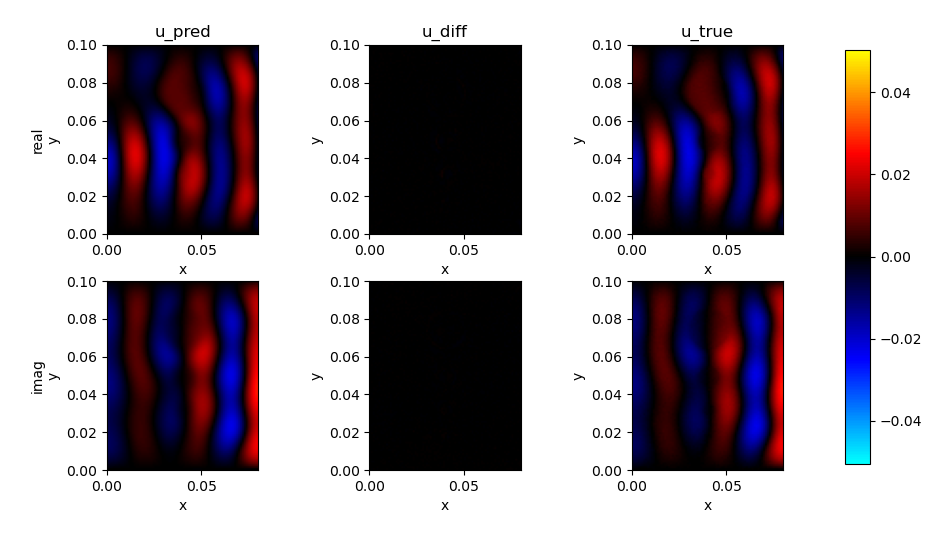

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

<IPython.core.display.Javascript object>


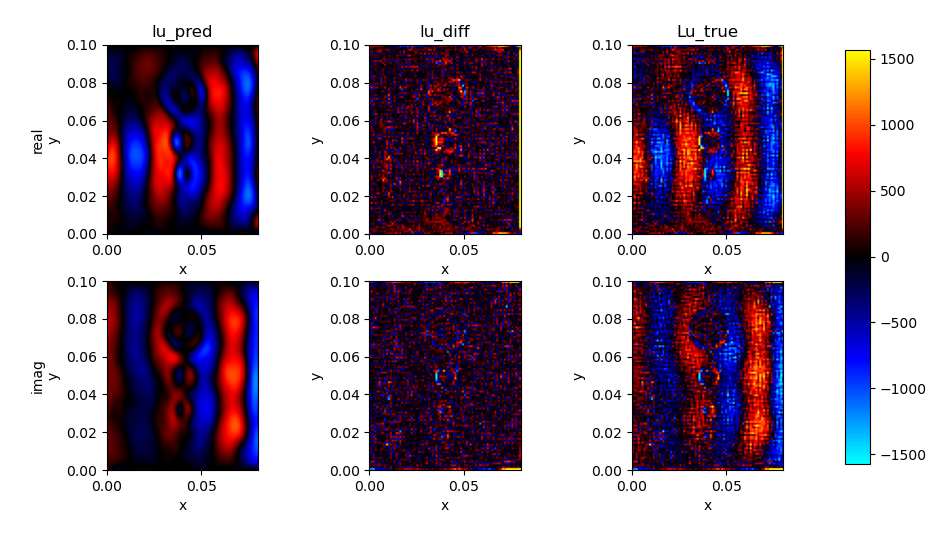

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

<IPython.core.display.Javascript object>


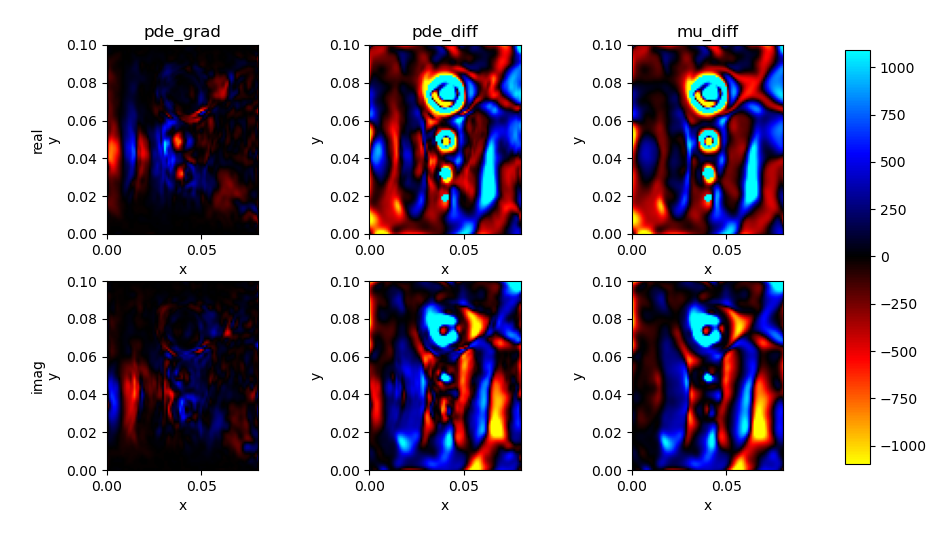

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

<IPython.core.display.Javascript object>


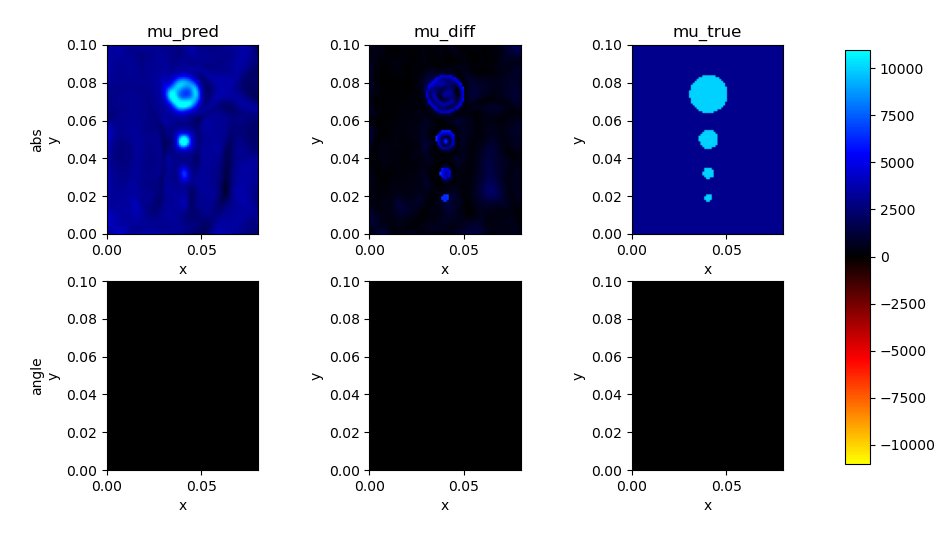

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

<IPython.core.display.Javascript object>


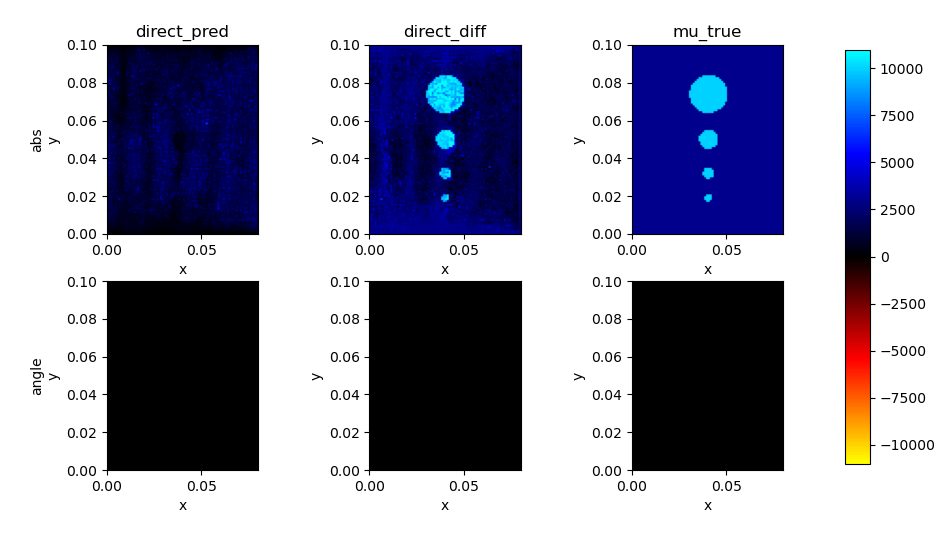

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

<IPython.core.display.Javascript object>


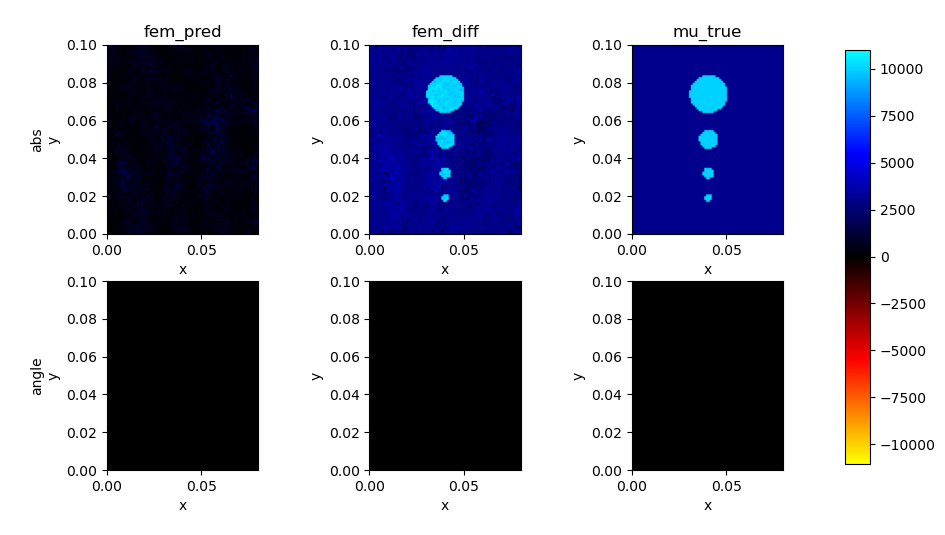

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

In [42]:
%autoreload
test_eval = mre_pinn.testing.TestEvaluator(test_every=100, interact=True)
test_eval.model = model
test_eval.test()

In [45]:
model.train(100000, display_every=10, callbacks=[test_eval])

Training model...

6309      [1.12e-07, 0.00e+00, 3.60e+00]    [1.10e-07, 0.00e+00, 3.70e+00]    []  
6310      [1.10e-07, 0.00e+00, 3.47e+00]    [1.10e-07, 0.00e+00, 3.69e+00]    []  
6320      [1.07e-07, 0.00e+00, 3.63e+00]    [1.09e-07, 0.00e+00, 3.71e+00]    []  
6330      [1.10e-07, 0.00e+00, 3.88e+00]    [1.09e-07, 0.00e+00, 3.69e+00]    []  
6340      [1.07e-07, 0.00e+00, 3.88e+00]    [1.10e-07, 0.00e+00, 3.67e+00]    []  
6350      [1.04e-07, 0.00e+00, 3.23e+00]    [1.09e-07, 0.00e+00, 3.71e+00]    []  
6360      [1.04e-07, 0.00e+00, 3.39e+00]    [1.09e-07, 0.00e+00, 3.65e+00]    []  
6370      [1.09e-07, 0.00e+00, 3.41e+00]    [1.09e-07, 0.00e+00, 3.64e+00]    []  
6380      [1.11e-07, 0.00e+00, 3.41e+00]    [1.10e-07, 0.00e+00, 3.70e+00]    []  
6390      [1.07e-07, 0.00e+00, 3.40e+00]    [1.08e-07, 0.00e+00, 3.67e+00]    []  
6400      [1.10e-07, 0.00e+00, 3.81e+00]    [1.08e-07, 0.00e+00, 3.65e+00]    []  
Time spent testing: 24.3834 (19.16%)
6410      [1.08e-07, 0.00e+00, 

7250      [1.01e-07, 0.00e+00, 2.83e+00]    [1.00e-07, 0.00e+00, 3.21e+00]    []  
7260      [9.83e-08, 0.00e+00, 3.16e+00]    [1.02e-07, 0.00e+00, 3.19e+00]    []  
7270      [1.01e-07, 0.00e+00, 3.31e+00]    [1.00e-07, 0.00e+00, 3.20e+00]    []  
7280      [9.62e-08, 0.00e+00, 3.04e+00]    [9.91e-08, 0.00e+00, 3.18e+00]    []  
7290      [1.02e-07, 0.00e+00, 3.02e+00]    [9.97e-08, 0.00e+00, 3.19e+00]    []  
7300      [9.53e-08, 0.00e+00, 3.06e+00]    [1.00e-07, 0.00e+00, 3.19e+00]    []  
Time spent testing: 19.3900 (21.03%)
7310      [9.72e-08, 0.00e+00, 2.99e+00]    [9.97e-08, 0.00e+00, 3.20e+00]    []  
7320      [1.02e-07, 0.00e+00, 3.06e+00]    [1.00e-07, 0.00e+00, 3.15e+00]    []  
7330      [1.03e-07, 0.00e+00, 3.34e+00]    [1.00e-07, 0.00e+00, 3.18e+00]    []  
7340      [1.01e-07, 0.00e+00, 3.07e+00]    [9.94e-08, 0.00e+00, 3.15e+00]    []  
7350      [1.04e-07, 0.00e+00, 3.09e+00]    [1.00e-07, 0.00e+00, 3.16e+00]    []  
7360      [1.03e-07, 0.00e+00, 3.06e+00]    [1.01e

8200      [9.58e-08, 0.00e+00, 2.62e+00]    [9.40e-08, 0.00e+00, 2.91e+00]    []  
Time spent testing: 18.1856 (22.79%)
8210      [9.02e-08, 0.00e+00, 2.75e+00]    [9.58e-08, 0.00e+00, 2.86e+00]    []  
8220      [8.95e-08, 0.00e+00, 2.86e+00]    [9.52e-08, 0.00e+00, 2.90e+00]    []  
8230      [9.73e-08, 0.00e+00, 2.52e+00]    [9.55e-08, 0.00e+00, 2.87e+00]    []  
8240      [9.32e-08, 0.00e+00, 2.81e+00]    [9.36e-08, 0.00e+00, 2.85e+00]    []  
8250      [9.48e-08, 0.00e+00, 2.87e+00]    [9.37e-08, 0.00e+00, 2.88e+00]    []  
8260      [8.94e-08, 0.00e+00, 2.84e+00]    [9.39e-08, 0.00e+00, 2.86e+00]    []  
8270      [1.00e-07, 0.00e+00, 2.93e+00]    [9.52e-08, 0.00e+00, 2.84e+00]    []  
8280      [9.70e-08, 0.00e+00, 2.80e+00]    [9.40e-08, 0.00e+00, 2.86e+00]    []  
8290      [1.00e-07, 0.00e+00, 2.69e+00]    [9.35e-08, 0.00e+00, 2.88e+00]    []  
8300      [9.19e-08, 0.00e+00, 2.73e+00]    [9.41e-08, 0.00e+00, 2.86e+00]    []  
Time spent testing: 20.2124 (22.99%)
8310      [9.

9150      [9.09e-08, 0.00e+00, 2.46e+00]    [8.98e-08, 0.00e+00, 2.62e+00]    []  
9160      [8.89e-08, 0.00e+00, 2.47e+00]    [8.91e-08, 0.00e+00, 2.62e+00]    []  
9170      [9.05e-08, 0.00e+00, 2.68e+00]    [8.92e-08, 0.00e+00, 2.60e+00]    []  
9180      [8.42e-08, 0.00e+00, 2.70e+00]    [8.94e-08, 0.00e+00, 2.65e+00]    []  
9190      [8.72e-08, 0.00e+00, 2.65e+00]    [8.88e-08, 0.00e+00, 2.67e+00]    []  
9200      [8.89e-08, 0.00e+00, 2.49e+00]    [8.78e-08, 0.00e+00, 2.63e+00]    []  
Time spent testing: 19.7702 (24.62%)
9210      [8.88e-08, 0.00e+00, 2.66e+00]    [8.83e-08, 0.00e+00, 2.67e+00]    []  
9220      [8.66e-08, 0.00e+00, 2.64e+00]    [8.76e-08, 0.00e+00, 2.67e+00]    []  
9230      [8.49e-08, 0.00e+00, 2.54e+00]    [8.87e-08, 0.00e+00, 2.64e+00]    []  
9240      [9.25e-08, 0.00e+00, 2.67e+00]    [8.89e-08, 0.00e+00, 2.63e+00]    []  
9250      [8.66e-08, 0.00e+00, 2.48e+00]    [8.85e-08, 0.00e+00, 2.64e+00]    []  
9260      [9.18e-08, 0.00e+00, 2.41e+00]    [9.22e

10100     [8.28e-08, 0.00e+00, 2.48e+01]    [8.65e-08, 0.00e+00, 2.59e+01]    []  
Time spent testing: 19.3721 (26.16%)
10110     [9.05e-08, 0.00e+00, 2.43e+01]    [8.57e-08, 0.00e+00, 2.52e+01]    []  
10120     [9.14e-08, 0.00e+00, 2.46e+01]    [8.72e-08, 0.00e+00, 2.51e+01]    []  
10130     [8.35e-08, 0.00e+00, 2.37e+01]    [8.51e-08, 0.00e+00, 2.47e+01]    []  
10140     [8.62e-08, 0.00e+00, 2.41e+01]    [8.54e-08, 0.00e+00, 2.47e+01]    []  
10150     [8.16e-08, 0.00e+00, 2.20e+01]    [8.54e-08, 0.00e+00, 2.43e+01]    []  
10160     [8.35e-08, 0.00e+00, 2.42e+01]    [8.63e-08, 0.00e+00, 2.48e+01]    []  
10170     [8.77e-08, 0.00e+00, 2.56e+01]    [8.59e-08, 0.00e+00, 2.52e+01]    []  
10180     [8.11e-08, 0.00e+00, 2.47e+01]    [8.48e-08, 0.00e+00, 2.54e+01]    []  
10190     [8.75e-08, 0.00e+00, 2.34e+01]    [8.54e-08, 0.00e+00, 2.51e+01]    []  
10200     [8.35e-08, 0.00e+00, 2.58e+01]    [8.60e-08, 0.00e+00, 2.51e+01]    []  
Time spent testing: 20.4266 (26.34%)
10210     [8.

11050     [8.67e-08, 0.00e+00, 2.39e+01]    [8.50e-08, 0.00e+00, 2.35e+01]    []  
11060     [8.35e-08, 0.00e+00, 2.47e+01]    [8.37e-08, 0.00e+00, 2.33e+01]    []  
11070     [7.91e-08, 0.00e+00, 2.24e+01]    [8.34e-08, 0.00e+00, 2.32e+01]    []  
11080     [8.50e-08, 0.00e+00, 2.44e+01]    [8.38e-08, 0.00e+00, 2.33e+01]    []  
11090     [8.34e-08, 0.00e+00, 2.16e+01]    [8.37e-08, 0.00e+00, 2.35e+01]    []  
11100     [8.09e-08, 0.00e+00, 2.23e+01]    [8.31e-08, 0.00e+00, 2.35e+01]    []  
Time spent testing: 20.7207 (27.76%)
11110     [8.18e-08, 0.00e+00, 2.42e+01]    [8.31e-08, 0.00e+00, 2.31e+01]    []  
11120     [8.21e-08, 0.00e+00, 2.55e+01]    [8.29e-08, 0.00e+00, 2.38e+01]    []  
11130     [8.42e-08, 0.00e+00, 2.29e+01]    [8.34e-08, 0.00e+00, 2.31e+01]    []  
11140     [8.52e-08, 0.00e+00, 2.39e+01]    [8.29e-08, 0.00e+00, 2.35e+01]    []  
11150     [7.76e-08, 0.00e+00, 2.25e+01]    [8.21e-08, 0.00e+00, 2.31e+01]    []  
11160     [8.46e-08, 0.00e+00, 2.38e+01]    [8.21e

12000     [7.91e-08, 0.00e+00, 2.16e+01]    [8.06e-08, 0.00e+00, 2.19e+01]    []  
Time spent testing: 19.5714 (29.09%)
12010     [8.02e-08, 0.00e+00, 2.13e+01]    [8.04e-08, 0.00e+00, 2.21e+01]    []  
12020     [7.86e-08, 0.00e+00, 2.17e+01]    [8.10e-08, 0.00e+00, 2.18e+01]    []  
12030     [7.76e-08, 0.00e+00, 2.11e+01]    [8.08e-08, 0.00e+00, 2.21e+01]    []  
12040     [8.17e-08, 0.00e+00, 2.22e+01]    [7.92e-08, 0.00e+00, 2.21e+01]    []  
12050     [8.01e-08, 0.00e+00, 2.15e+01]    [7.99e-08, 0.00e+00, 2.20e+01]    []  
12060     [7.74e-08, 0.00e+00, 2.24e+01]    [8.04e-08, 0.00e+00, 2.22e+01]    []  
12070     [8.06e-08, 0.00e+00, 2.27e+01]    [8.04e-08, 0.00e+00, 2.22e+01]    []  
12080     [8.31e-08, 0.00e+00, 2.04e+01]    [8.09e-08, 0.00e+00, 2.20e+01]    []  
12090     [8.21e-08, 0.00e+00, 2.11e+01]    [8.09e-08, 0.00e+00, 2.17e+01]    []  
12100     [8.26e-08, 0.00e+00, 2.14e+01]    [8.06e-08, 0.00e+00, 2.21e+01]    []  
Time spent testing: 18.2869 (29.23%)
12110     [8.

12950     [8.11e-08, 0.00e+00, 2.11e+01]    [7.94e-08, 0.00e+00, 2.16e+01]    []  
12960     [7.82e-08, 0.00e+00, 2.02e+01]    [7.78e-08, 0.00e+00, 2.13e+01]    []  
12970     [7.77e-08, 0.00e+00, 2.10e+01]    [7.91e-08, 0.00e+00, 2.13e+01]    []  
12980     [7.52e-08, 0.00e+00, 2.06e+01]    [7.88e-08, 0.00e+00, 2.13e+01]    []  
12990     [8.35e-08, 0.00e+00, 2.00e+01]    [7.92e-08, 0.00e+00, 2.15e+01]    []  
13000     [7.63e-08, 0.00e+00, 1.93e+01]    [7.88e-08, 0.00e+00, 2.11e+01]    []  
Time spent testing: 18.3647 (30.48%)
13010     [8.22e-08, 0.00e+00, 2.14e+01]    [7.90e-08, 0.00e+00, 2.11e+01]    []  
13020     [8.22e-08, 0.00e+00, 2.08e+01]    [7.84e-08, 0.00e+00, 2.10e+01]    []  
13030     [7.89e-08, 0.00e+00, 1.96e+01]    [7.85e-08, 0.00e+00, 2.12e+01]    []  
13040     [7.52e-08, 0.00e+00, 1.99e+01]    [7.92e-08, 0.00e+00, 2.15e+01]    []  
13050     [7.60e-08, 0.00e+00, 2.13e+01]    [7.84e-08, 0.00e+00, 2.16e+01]    []  
13060     [8.08e-08, 0.00e+00, 2.12e+01]    [7.90e

13900     [7.77e-08, 0.00e+00, 2.07e+01]    [7.68e-08, 0.00e+00, 2.10e+01]    []  
Time spent testing: 18.7866 (31.67%)
13910     [7.97e-08, 0.00e+00, 2.15e+01]    [7.81e-08, 0.00e+00, 2.11e+01]    []  
13920     [7.87e-08, 0.00e+00, 2.04e+01]    [7.79e-08, 0.00e+00, 2.08e+01]    []  
13930     [8.11e-08, 0.00e+00, 2.10e+01]    [7.83e-08, 0.00e+00, 2.08e+01]    []  
13940     [8.10e-08, 0.00e+00, 1.96e+01]    [7.86e-08, 0.00e+00, 2.12e+01]    []  
13950     [7.83e-08, 0.00e+00, 2.04e+01]    [7.72e-08, 0.00e+00, 2.11e+01]    []  
13960     [7.55e-08, 0.00e+00, 2.09e+01]    [7.87e-08, 0.00e+00, 2.09e+01]    []  
13970     [7.78e-08, 0.00e+00, 2.02e+01]    [7.78e-08, 0.00e+00, 2.10e+01]    []  
13980     [8.08e-08, 0.00e+00, 2.30e+01]    [7.68e-08, 0.00e+00, 2.11e+01]    []  
13990     [7.86e-08, 0.00e+00, 2.13e+01]    [7.84e-08, 0.00e+00, 2.10e+01]    []  
14000     [8.19e-08, 0.00e+00, 2.06e+01]    [7.88e-08, 0.00e+00, 2.05e+01]    []  
Time spent testing: 19.7590 (31.80%)
14010     [8.

14850     [7.53e-08, 0.00e+00, 2.08e+01]    [7.68e-08, 0.00e+00, 2.08e+01]    []  
14860     [7.30e-08, 0.00e+00, 1.88e+01]    [7.61e-08, 0.00e+00, 2.06e+01]    []  
14870     [7.69e-08, 0.00e+00, 1.90e+01]    [7.67e-08, 0.00e+00, 2.03e+01]    []  
14880     [7.56e-08, 0.00e+00, 1.97e+01]    [7.60e-08, 0.00e+00, 2.07e+01]    []  
14890     [7.45e-08, 0.00e+00, 2.10e+01]    [7.59e-08, 0.00e+00, 2.08e+01]    []  
14900     [7.48e-08, 0.00e+00, 1.97e+01]    [7.50e-08, 0.00e+00, 2.04e+01]    []  
Time spent testing: 20.5409 (32.93%)
14910     [7.34e-08, 0.00e+00, 1.93e+01]    [7.47e-08, 0.00e+00, 2.08e+01]    []  
14920     [7.95e-08, 0.00e+00, 1.95e+01]    [7.50e-08, 0.00e+00, 2.03e+01]    []  
14930     [7.06e-08, 0.00e+00, 2.07e+01]    [7.53e-08, 0.00e+00, 2.04e+01]    []  
14940     [7.40e-08, 0.00e+00, 1.96e+01]    [7.58e-08, 0.00e+00, 2.08e+01]    []  
14950     [7.48e-08, 0.00e+00, 2.05e+01]    [7.63e-08, 0.00e+00, 2.09e+01]    []  
14960     [7.62e-08, 0.00e+00, 1.93e+01]    [7.66e

15800     [7.66e-08, 0.00e+00, 1.98e+02]    [7.59e-08, 0.00e+00, 2.03e+02]    []  
Time spent testing: 21.3675 (34.01%)
15810     [7.35e-08, 0.00e+00, 2.07e+02]    [7.45e-08, 0.00e+00, 2.00e+02]    []  
15820     [7.20e-08, 0.00e+00, 1.96e+02]    [7.50e-08, 0.00e+00, 2.05e+02]    []  
15830     [7.50e-08, 0.00e+00, 1.86e+02]    [7.54e-08, 0.00e+00, 2.02e+02]    []  
15840     [7.34e-08, 0.00e+00, 1.98e+02]    [7.42e-08, 0.00e+00, 2.05e+02]    []  
15850     [7.77e-08, 0.00e+00, 2.05e+02]    [7.47e-08, 0.00e+00, 2.02e+02]    []  
15860     [7.51e-08, 0.00e+00, 1.92e+02]    [7.36e-08, 0.00e+00, 2.03e+02]    []  
15870     [7.48e-08, 0.00e+00, 2.08e+02]    [7.39e-08, 0.00e+00, 2.04e+02]    []  
15880     [7.30e-08, 0.00e+00, 1.86e+02]    [7.52e-08, 0.00e+00, 2.02e+02]    []  
15890     [7.74e-08, 0.00e+00, 1.93e+02]    [7.58e-08, 0.00e+00, 1.99e+02]    []  
15900     [7.45e-08, 0.00e+00, 2.05e+02]    [7.50e-08, 0.00e+00, 2.03e+02]    []  
Time spent testing: 19.6709 (34.13%)
15910     [7.

16750     [7.79e-08, 0.00e+00, 2.09e+02]    [7.36e-08, 0.00e+00, 1.94e+02]    []  
16760     [7.84e-08, 0.00e+00, 2.02e+02]    [7.33e-08, 0.00e+00, 1.94e+02]    []  
16770     [7.64e-08, 0.00e+00, 1.88e+02]    [7.29e-08, 0.00e+00, 1.98e+02]    []  
16780     [7.44e-08, 0.00e+00, 1.87e+02]    [7.33e-08, 0.00e+00, 1.96e+02]    []  
16790     [7.40e-08, 0.00e+00, 1.99e+02]    [7.40e-08, 0.00e+00, 1.95e+02]    []  
16800     [7.08e-08, 0.00e+00, 1.85e+02]    [7.32e-08, 0.00e+00, 1.97e+02]    []  
Time spent testing: 20.5227 (35.15%)
16810     [7.21e-08, 0.00e+00, 1.93e+02]    [7.28e-08, 0.00e+00, 1.97e+02]    []  
16820     [7.60e-08, 0.00e+00, 1.82e+02]    [7.36e-08, 0.00e+00, 1.97e+02]    []  
16830     [7.26e-08, 0.00e+00, 1.92e+02]    [7.35e-08, 0.00e+00, 1.97e+02]    []  
16840     [7.26e-08, 0.00e+00, 1.94e+02]    [7.28e-08, 0.00e+00, 1.96e+02]    []  
16850     [7.45e-08, 0.00e+00, 1.89e+02]    [7.50e-08, 0.00e+00, 1.99e+02]    []  
16860     [7.33e-08, 0.00e+00, 1.85e+02]    [7.32e

17700     [6.94e-08, 0.00e+00, 1.88e+02]    [7.24e-08, 0.00e+00, 2.01e+02]    []  
Time spent testing: 19.8536 (36.11%)
17710     [7.16e-08, 0.00e+00, 1.77e+02]    [7.25e-08, 0.00e+00, 2.01e+02]    []  
17720     [7.04e-08, 0.00e+00, 1.96e+02]    [7.27e-08, 0.00e+00, 1.99e+02]    []  
17730     [7.11e-08, 0.00e+00, 1.84e+02]    [7.21e-08, 0.00e+00, 1.97e+02]    []  
17740     [7.25e-08, 0.00e+00, 1.78e+02]    [7.29e-08, 0.00e+00, 1.97e+02]    []  
17750     [7.73e-08, 0.00e+00, 1.94e+02]    [7.32e-08, 0.00e+00, 1.96e+02]    []  
17760     [7.54e-08, 0.00e+00, 1.85e+02]    [7.28e-08, 0.00e+00, 1.94e+02]    []  
17770     [7.31e-08, 0.00e+00, 1.96e+02]    [7.27e-08, 0.00e+00, 1.97e+02]    []  
17780     [7.36e-08, 0.00e+00, 1.96e+02]    [7.36e-08, 0.00e+00, 1.98e+02]    []  
17790     [7.29e-08, 0.00e+00, 1.89e+02]    [7.27e-08, 0.00e+00, 1.94e+02]    []  
17800     [7.68e-08, 0.00e+00, 1.98e+02]    [7.30e-08, 0.00e+00, 1.94e+02]    []  
Time spent testing: 18.7047 (36.21%)
17810     [7.

18650     [6.96e-08, 0.00e+00, 1.76e+02]    [7.23e-08, 0.00e+00, 1.95e+02]    []  
18660     [7.18e-08, 0.00e+00, 1.99e+02]    [7.17e-08, 0.00e+00, 1.95e+02]    []  
18670     [6.77e-08, 0.00e+00, 1.80e+02]    [7.33e-08, 0.00e+00, 1.96e+02]    []  
18680     [7.43e-08, 0.00e+00, 1.97e+02]    [7.22e-08, 0.00e+00, 1.93e+02]    []  
18690     [7.10e-08, 0.00e+00, 1.83e+02]    [7.23e-08, 0.00e+00, 1.98e+02]    []  
18700     [7.23e-08, 0.00e+00, 1.91e+02]    [7.35e-08, 0.00e+00, 1.95e+02]    []  
Time spent testing: 19.9744 (37.12%)
18710     [7.31e-08, 0.00e+00, 1.88e+02]    [7.23e-08, 0.00e+00, 1.95e+02]    []  
18720     [6.97e-08, 0.00e+00, 1.88e+02]    [7.18e-08, 0.00e+00, 1.95e+02]    []  
18730     [7.19e-08, 0.00e+00, 2.01e+02]    [7.10e-08, 0.00e+00, 1.94e+02]    []  
18740     [7.31e-08, 0.00e+00, 1.87e+02]    [7.13e-08, 0.00e+00, 1.94e+02]    []  
18750     [7.26e-08, 0.00e+00, 1.91e+02]    [7.25e-08, 0.00e+00, 1.96e+02]    []  
18760     [7.11e-08, 0.00e+00, 1.82e+02]    [7.26e

19600     [6.85e-08, 0.00e+00, 1.90e+02]    [7.12e-08, 0.00e+00, 1.92e+02]    []  
Time spent testing: 18.9131 (38.01%)
19610     [6.98e-08, 0.00e+00, 1.97e+02]    [7.13e-08, 0.00e+00, 1.94e+02]    []  
19620     [6.72e-08, 0.00e+00, 1.79e+02]    [7.18e-08, 0.00e+00, 1.92e+02]    []  
19630     [7.15e-08, 0.00e+00, 1.85e+02]    [7.36e-08, 0.00e+00, 1.90e+02]    []  
19640     [7.31e-08, 0.00e+00, 1.78e+02]    [7.14e-08, 0.00e+00, 1.92e+02]    []  
19650     [7.16e-08, 0.00e+00, 1.88e+02]    [7.12e-08, 0.00e+00, 1.93e+02]    []  
19660     [7.30e-08, 0.00e+00, 1.93e+02]    [7.16e-08, 0.00e+00, 1.94e+02]    []  
19670     [7.06e-08, 0.00e+00, 1.95e+02]    [7.11e-08, 0.00e+00, 1.92e+02]    []  
19680     [7.39e-08, 0.00e+00, 1.81e+02]    [7.12e-08, 0.00e+00, 1.90e+02]    []  
19690     [7.27e-08, 0.00e+00, 1.74e+02]    [7.18e-08, 0.00e+00, 1.90e+02]    []  
19700     [7.27e-08, 0.00e+00, 1.82e+02]    [7.20e-08, 0.00e+00, 1.89e+02]    []  
Time spent testing: 20.0359 (38.10%)
19710     [6.

20550     [6.93e-08, 0.00e+00, 1.81e+03]    [7.11e-08, 0.00e+00, 1.90e+03]    []  
20560     [6.99e-08, 0.00e+00, 1.83e+03]    [7.06e-08, 0.00e+00, 1.90e+03]    []  
20570     [7.22e-08, 0.00e+00, 1.84e+03]    [7.11e-08, 0.00e+00, 1.88e+03]    []  
20580     [6.90e-08, 0.00e+00, 1.85e+03]    [7.09e-08, 0.00e+00, 1.89e+03]    []  
20590     [7.08e-08, 0.00e+00, 1.85e+03]    [7.11e-08, 0.00e+00, 1.89e+03]    []  
20600     [7.00e-08, 0.00e+00, 1.91e+03]    [7.21e-08, 0.00e+00, 1.90e+03]    []  
Time spent testing: 19.9598 (38.94%)
20610     [7.05e-08, 0.00e+00, 1.81e+03]    [7.17e-08, 0.00e+00, 1.89e+03]    []  
20620     [7.27e-08, 0.00e+00, 1.86e+03]    [7.14e-08, 0.00e+00, 1.92e+03]    []  
20630     [7.17e-08, 0.00e+00, 1.80e+03]    [7.03e-08, 0.00e+00, 1.95e+03]    []  
20640     [7.16e-08, 0.00e+00, 1.90e+03]    [7.02e-08, 0.00e+00, 1.94e+03]    []  
20650     [6.72e-08, 0.00e+00, 1.87e+03]    [6.99e-08, 0.00e+00, 1.92e+03]    []  
20660     [7.19e-08, 0.00e+00, 1.91e+03]    [7.07e

21500     [7.04e-08, 0.00e+00, 1.94e+03]    [6.99e-08, 0.00e+00, 1.91e+03]    []  
Time spent testing: 18.9340 (39.74%)
21510     [7.13e-08, 0.00e+00, 1.83e+03]    [7.00e-08, 0.00e+00, 1.87e+03]    []  
21520     [7.08e-08, 0.00e+00, 1.79e+03]    [7.06e-08, 0.00e+00, 1.86e+03]    []  
21530     [7.01e-08, 0.00e+00, 1.88e+03]    [6.98e-08, 0.00e+00, 1.87e+03]    []  
21540     [6.93e-08, 0.00e+00, 1.84e+03]    [6.97e-08, 0.00e+00, 1.89e+03]    []  
21550     [6.98e-08, 0.00e+00, 1.84e+03]    [6.94e-08, 0.00e+00, 1.90e+03]    []  
21560     [7.30e-08, 0.00e+00, 1.75e+03]    [7.09e-08, 0.00e+00, 1.85e+03]    []  
21570     [6.87e-08, 0.00e+00, 1.86e+03]    [7.04e-08, 0.00e+00, 1.86e+03]    []  
21580     [7.28e-08, 0.00e+00, 1.82e+03]    [7.00e-08, 0.00e+00, 1.87e+03]    []  
21590     [7.13e-08, 0.00e+00, 1.81e+03]    [7.09e-08, 0.00e+00, 1.86e+03]    []  
21600     [7.61e-08, 0.00e+00, 1.89e+03]    [6.96e-08, 0.00e+00, 1.86e+03]    []  
Time spent testing: 21.1302 (39.84%)
21610     [7.

22450     [7.58e-08, 0.00e+00, 1.73e+03]    [6.92e-08, 0.00e+00, 1.81e+03]    []  
22460     [7.10e-08, 0.00e+00, 1.72e+03]    [6.90e-08, 0.00e+00, 1.83e+03]    []  
22470     [7.00e-08, 0.00e+00, 1.81e+03]    [6.92e-08, 0.00e+00, 1.83e+03]    []  
22480     [6.58e-08, 0.00e+00, 1.75e+03]    [7.15e-08, 0.00e+00, 1.88e+03]    []  
22490     [6.79e-08, 0.00e+00, 1.78e+03]    [6.98e-08, 0.00e+00, 1.85e+03]    []  
22500     [6.91e-08, 0.00e+00, 1.79e+03]    [6.92e-08, 0.00e+00, 1.86e+03]    []  
Time spent testing: 19.0619 (40.59%)
22510     [6.80e-08, 0.00e+00, 1.77e+03]    [6.99e-08, 0.00e+00, 1.85e+03]    []  
22520     [6.91e-08, 0.00e+00, 1.88e+03]    [6.93e-08, 0.00e+00, 1.84e+03]    []  
22530     [7.10e-08, 0.00e+00, 1.94e+03]    [6.93e-08, 0.00e+00, 1.83e+03]    []  
22540     [7.06e-08, 0.00e+00, 1.80e+03]    [6.96e-08, 0.00e+00, 1.80e+03]    []  
22550     [7.35e-08, 0.00e+00, 1.80e+03]    [6.95e-08, 0.00e+00, 1.87e+03]    []  
22560     [7.29e-08, 0.00e+00, 1.75e+03]    [7.00e

23400     [6.71e-08, 0.00e+00, 1.84e+03]    [6.81e-08, 0.00e+00, 1.86e+03]    []  
Time spent testing: 20.3082 (41.31%)
23410     [6.93e-08, 0.00e+00, 1.93e+03]    [6.88e-08, 0.00e+00, 1.81e+03]    []  
23420     [7.27e-08, 0.00e+00, 1.81e+03]    [6.94e-08, 0.00e+00, 1.83e+03]    []  
23430     [7.14e-08, 0.00e+00, 1.79e+03]    [6.88e-08, 0.00e+00, 1.85e+03]    []  
23440     [6.94e-08, 0.00e+00, 1.79e+03]    [6.93e-08, 0.00e+00, 1.85e+03]    []  
23450     [7.00e-08, 0.00e+00, 1.82e+03]    [6.93e-08, 0.00e+00, 1.87e+03]    []  
23460     [7.14e-08, 0.00e+00, 1.84e+03]    [6.86e-08, 0.00e+00, 1.83e+03]    []  
23470     [7.15e-08, 0.00e+00, 1.79e+03]    [6.85e-08, 0.00e+00, 1.83e+03]    []  
23480     [7.06e-08, 0.00e+00, 1.74e+03]    [6.89e-08, 0.00e+00, 1.85e+03]    []  
23490     [7.42e-08, 0.00e+00, 1.81e+03]    [6.91e-08, 0.00e+00, 1.82e+03]    []  
23500     [6.98e-08, 0.00e+00, 1.76e+03]    [6.88e-08, 0.00e+00, 1.84e+03]    []  
Time spent testing: 19.0802 (41.38%)
23510     [6.

24350     [7.00e-08, 0.00e+00, 1.81e+03]    [7.02e-08, 0.00e+00, 1.85e+03]    []  
24360     [7.00e-08, 0.00e+00, 1.72e+03]    [6.93e-08, 0.00e+00, 1.80e+03]    []  
24370     [6.94e-08, 0.00e+00, 1.72e+03]    [7.15e-08, 0.00e+00, 1.80e+03]    []  
24380     [6.73e-08, 0.00e+00, 1.73e+03]    [6.84e-08, 0.00e+00, 1.79e+03]    []  
24390     [6.96e-08, 0.00e+00, 1.84e+03]    [6.92e-08, 0.00e+00, 1.83e+03]    []  
24400     [6.97e-08, 0.00e+00, 1.86e+03]    [6.90e-08, 0.00e+00, 1.80e+03]    []  
Time spent testing: 20.4515 (42.09%)
24410     [6.57e-08, 0.00e+00, 1.75e+03]    [6.82e-08, 0.00e+00, 1.82e+03]    []  
24420     [6.98e-08, 0.00e+00, 1.84e+03]    [6.88e-08, 0.00e+00, 1.84e+03]    []  
24430     [7.42e-08, 0.00e+00, 1.83e+03]    [6.87e-08, 0.00e+00, 1.82e+03]    []  
24440     [6.97e-08, 0.00e+00, 1.85e+03]    [6.98e-08, 0.00e+00, 1.83e+03]    []  
24450     [6.81e-08, 0.00e+00, 1.81e+03]    [6.88e-08, 0.00e+00, 1.86e+03]    []  
24460     [6.91e-08, 0.00e+00, 1.75e+03]    [6.98e

25300     [7.26e-08, 0.00e+00, 1.74e+04]    [6.93e-08, 0.00e+00, 1.84e+04]    []  
Time spent testing: 21.4308 (42.76%)
25310     [6.75e-08, 0.00e+00, 1.79e+04]    [6.82e-08, 0.00e+00, 1.87e+04]    []  
25320     [6.77e-08, 0.00e+00, 1.79e+04]    [6.78e-08, 0.00e+00, 1.84e+04]    []  
25330     [6.78e-08, 0.00e+00, 1.76e+04]    [6.84e-08, 0.00e+00, 1.85e+04]    []  
25340     [6.77e-08, 0.00e+00, 1.76e+04]    [6.78e-08, 0.00e+00, 1.90e+04]    []  
25350     [6.92e-08, 0.00e+00, 1.69e+04]    [6.76e-08, 0.00e+00, 1.85e+04]    []  
25360     [6.84e-08, 0.00e+00, 1.85e+04]    [6.74e-08, 0.00e+00, 1.78e+04]    []  
25370     [6.67e-08, 0.00e+00, 1.71e+04]    [6.83e-08, 0.00e+00, 1.82e+04]    []  
25380     [6.64e-08, 0.00e+00, 1.78e+04]    [6.77e-08, 0.00e+00, 1.86e+04]    []  
25390     [6.76e-08, 0.00e+00, 1.81e+04]    [6.75e-08, 0.00e+00, 1.88e+04]    []  
25400     [6.62e-08, 0.00e+00, 1.69e+04]    [6.86e-08, 0.00e+00, 1.85e+04]    []  
Time spent testing: 20.2842 (42.83%)
25410     [6.

26250     [6.80e-08, 0.00e+00, 1.74e+04]    [6.78e-08, 0.00e+00, 1.83e+04]    []  
26260     [6.52e-08, 0.00e+00, 1.77e+04]    [6.82e-08, 0.00e+00, 1.83e+04]    []  
26270     [6.88e-08, 0.00e+00, 1.70e+04]    [6.82e-08, 0.00e+00, 1.80e+04]    []  
26280     [6.55e-08, 0.00e+00, 1.72e+04]    [6.77e-08, 0.00e+00, 1.84e+04]    []  
26290     [6.97e-08, 0.00e+00, 1.73e+04]    [6.81e-08, 0.00e+00, 1.82e+04]    []  
26300     [6.45e-08, 0.00e+00, 1.79e+04]    [6.81e-08, 0.00e+00, 1.80e+04]    []  
Time spent testing: 20.5274 (43.49%)
26310     [6.49e-08, 0.00e+00, 1.92e+04]    [6.84e-08, 0.00e+00, 1.83e+04]    []  
26320     [7.18e-08, 0.00e+00, 1.80e+04]    [6.82e-08, 0.00e+00, 1.85e+04]    []  
26330     [6.95e-08, 0.00e+00, 1.82e+04]    [6.81e-08, 0.00e+00, 1.84e+04]    []  
26340     [6.69e-08, 0.00e+00, 1.81e+04]    [6.80e-08, 0.00e+00, 1.82e+04]    []  
26350     [6.36e-08, 0.00e+00, 1.81e+04]    [6.87e-08, 0.00e+00, 1.83e+04]    []  
26360     [7.06e-08, 0.00e+00, 1.67e+04]    [6.96e

27200     [7.00e-08, 0.00e+00, 1.90e+04]    [6.68e-08, 0.00e+00, 1.79e+04]    []  
Time spent testing: 21.6197 (44.10%)
27210     [6.91e-08, 0.00e+00, 1.70e+04]    [6.74e-08, 0.00e+00, 1.82e+04]    []  
27220     [6.48e-08, 0.00e+00, 1.63e+04]    [6.80e-08, 0.00e+00, 1.80e+04]    []  
27230     [6.80e-08, 0.00e+00, 1.76e+04]    [6.74e-08, 0.00e+00, 1.79e+04]    []  
27240     [6.52e-08, 0.00e+00, 1.78e+04]    [6.84e-08, 0.00e+00, 1.76e+04]    []  
27250     [6.48e-08, 0.00e+00, 1.72e+04]    [6.69e-08, 0.00e+00, 1.78e+04]    []  
27260     [6.61e-08, 0.00e+00, 1.67e+04]    [6.73e-08, 0.00e+00, 1.80e+04]    []  
27270     [6.82e-08, 0.00e+00, 1.73e+04]    [6.75e-08, 0.00e+00, 1.81e+04]    []  
27280     [6.63e-08, 0.00e+00, 1.76e+04]    [6.72e-08, 0.00e+00, 1.82e+04]    []  
27290     [6.54e-08, 0.00e+00, 1.64e+04]    [6.70e-08, 0.00e+00, 1.83e+04]    []  
27300     [6.94e-08, 0.00e+00, 1.60e+04]    [6.72e-08, 0.00e+00, 1.84e+04]    []  
Time spent testing: 19.3477 (44.16%)
27310     [6.

28150     [6.67e-08, 0.00e+00, 1.79e+04]    [6.63e-08, 0.00e+00, 1.78e+04]    []  
28160     [6.53e-08, 0.00e+00, 1.78e+04]    [6.68e-08, 0.00e+00, 1.79e+04]    []  
28170     [6.87e-08, 0.00e+00, 1.79e+04]    [6.72e-08, 0.00e+00, 1.82e+04]    []  
28180     [6.90e-08, 0.00e+00, 1.73e+04]    [6.61e-08, 0.00e+00, 1.78e+04]    []  
28190     [6.72e-08, 0.00e+00, 1.71e+04]    [6.71e-08, 0.00e+00, 1.77e+04]    []  
28200     [7.39e-08, 0.00e+00, 1.76e+04]    [6.69e-08, 0.00e+00, 1.82e+04]    []  
Time spent testing: 20.7574 (44.75%)
28210     [6.49e-08, 0.00e+00, 1.68e+04]    [6.81e-08, 0.00e+00, 1.77e+04]    []  
28220     [6.89e-08, 0.00e+00, 1.87e+04]    [6.75e-08, 0.00e+00, 1.78e+04]    []  
28230     [6.91e-08, 0.00e+00, 1.73e+04]    [6.74e-08, 0.00e+00, 1.77e+04]    []  
28240     [6.68e-08, 0.00e+00, 1.74e+04]    [6.71e-08, 0.00e+00, 1.79e+04]    []  
28250     [6.60e-08, 0.00e+00, 1.74e+04]    [6.69e-08, 0.00e+00, 1.79e+04]    []  
28260     [6.68e-08, 0.00e+00, 1.72e+04]    [6.67e

29100     [6.45e-08, 0.00e+00, 1.61e+04]    [6.61e-08, 0.00e+00, 1.76e+04]    []  
Time spent testing: 21.6544 (45.33%)
29110     [6.44e-08, 0.00e+00, 1.71e+04]    [6.66e-08, 0.00e+00, 1.75e+04]    []  
29120     [6.91e-08, 0.00e+00, 1.75e+04]    [6.59e-08, 0.00e+00, 1.78e+04]    []  
29130     [6.81e-08, 0.00e+00, 1.79e+04]    [6.63e-08, 0.00e+00, 1.78e+04]    []  
29140     [6.78e-08, 0.00e+00, 1.68e+04]    [6.66e-08, 0.00e+00, 1.76e+04]    []  
29150     [6.65e-08, 0.00e+00, 1.61e+04]    [6.65e-08, 0.00e+00, 1.80e+04]    []  
29160     [6.76e-08, 0.00e+00, 1.76e+04]    [6.80e-08, 0.00e+00, 1.80e+04]    []  
29170     [6.86e-08, 0.00e+00, 1.67e+04]    [6.67e-08, 0.00e+00, 1.77e+04]    []  
29180     [6.88e-08, 0.00e+00, 1.68e+04]    [6.83e-08, 0.00e+00, 1.79e+04]    []  
29190     [6.78e-08, 0.00e+00, 1.73e+04]    [6.71e-08, 0.00e+00, 1.79e+04]    []  
29200     [6.61e-08, 0.00e+00, 1.77e+04]    [6.66e-08, 0.00e+00, 1.77e+04]    []  
Time spent testing: 19.4891 (45.39%)
29210     [6.

30050     [6.59e-08, 0.00e+00, 1.69e+04]    [6.68e-08, 0.00e+00, 1.78e+04]    []  
30060     [6.34e-08, 0.00e+00, 1.69e+04]    [6.69e-08, 0.00e+00, 1.75e+04]    []  
30070     [6.35e-08, 0.00e+00, 1.72e+04]    [6.68e-08, 0.00e+00, 1.72e+04]    []  
30080     [6.42e-08, 0.00e+00, 1.85e+04]    [6.64e-08, 0.00e+00, 1.72e+04]    []  
30090     [6.61e-08, 0.00e+00, 1.70e+04]    [6.61e-08, 0.00e+00, 1.73e+04]    []  
30100     [6.36e-08, 0.00e+00, 1.69e+04]    [6.54e-08, 0.00e+00, 1.74e+04]    []  
Time spent testing: 19.6395 (45.94%)
30110     [6.79e-08, 0.00e+00, 1.70e+04]    [6.57e-08, 0.00e+00, 1.73e+04]    []  
30120     [6.41e-08, 0.00e+00, 1.77e+04]    [6.55e-08, 0.00e+00, 1.76e+04]    []  
30130     [6.55e-08, 0.00e+00, 1.71e+04]    [6.58e-08, 0.00e+00, 1.75e+04]    []  
30140     [6.95e-08, 0.00e+00, 1.70e+04]    [6.52e-08, 0.00e+00, 1.77e+04]    []  
30150     [6.78e-08, 0.00e+00, 1.73e+04]    [6.59e-08, 0.00e+00, 1.76e+04]    []  
30160     [6.38e-08, 0.00e+00, 1.66e+04]    [6.60e

31000     [6.99e-08, 0.00e+00, 1.75e+04]    [6.62e-08, 0.00e+00, 1.80e+04]    []  
Time spent testing: 20.2254 (46.47%)
31010     [6.76e-08, 0.00e+00, 1.70e+04]    [6.65e-08, 0.00e+00, 1.77e+04]    []  
31020     [6.49e-08, 0.00e+00, 1.63e+04]    [6.63e-08, 0.00e+00, 1.76e+04]    []  
31030     [6.56e-08, 0.00e+00, 1.75e+04]    [6.61e-08, 0.00e+00, 1.73e+04]    []  
31040     [6.45e-08, 0.00e+00, 1.76e+04]    [6.63e-08, 0.00e+00, 1.77e+04]    []  
31050     [6.54e-08, 0.00e+00, 1.74e+04]    [6.61e-08, 0.00e+00, 1.76e+04]    []  
31060     [6.63e-08, 0.00e+00, 1.76e+04]    [6.52e-08, 0.00e+00, 1.78e+04]    []  
31070     [6.82e-08, 0.00e+00, 1.80e+04]    [6.58e-08, 0.00e+00, 1.80e+04]    []  
31080     [6.66e-08, 0.00e+00, 1.70e+04]    [6.65e-08, 0.00e+00, 1.80e+04]    []  
31090     [6.85e-08, 0.00e+00, 1.75e+04]    [6.61e-08, 0.00e+00, 1.78e+04]    []  
31100     [6.25e-08, 0.00e+00, 1.77e+04]    [6.59e-08, 0.00e+00, 1.79e+04]    []  
Time spent testing: 22.2780 (46.53%)
31110     [6.

31950     [6.65e-08, 0.00e+00, 1.73e+04]    [6.54e-08, 0.00e+00, 1.78e+04]    []  
31960     [6.59e-08, 0.00e+00, 1.61e+04]    [6.52e-08, 0.00e+00, 1.73e+04]    []  
31970     [6.45e-08, 0.00e+00, 1.66e+04]    [6.57e-08, 0.00e+00, 1.77e+04]    []  
31980     [6.76e-08, 0.00e+00, 1.70e+04]    [6.59e-08, 0.00e+00, 1.77e+04]    []  
31990     [6.52e-08, 0.00e+00, 1.68e+04]    [6.51e-08, 0.00e+00, 1.81e+04]    []  
32000     [6.82e-08, 0.00e+00, 1.73e+04]    [6.58e-08, 0.00e+00, 1.76e+04]    []  
Time spent testing: 20.9329 (47.04%)
32010     [7.00e-08, 0.00e+00, 1.68e+04]    [6.66e-08, 0.00e+00, 1.80e+04]    []  
32020     [6.60e-08, 0.00e+00, 1.83e+04]    [6.59e-08, 0.00e+00, 1.79e+04]    []  
32030     [6.73e-08, 0.00e+00, 1.66e+04]    [6.58e-08, 0.00e+00, 1.79e+04]    []  
32040     [6.84e-08, 0.00e+00, 1.67e+04]    [6.68e-08, 0.00e+00, 1.81e+04]    []  
32050     [6.43e-08, 0.00e+00, 1.64e+04]    [6.62e-08, 0.00e+00, 1.78e+04]    []  
32060     [6.56e-08, 0.00e+00, 1.62e+04]    [6.75e

32900     [6.39e-08, 0.00e+00, 1.73e+04]    [6.58e-08, 0.00e+00, 1.75e+04]    []  
Time spent testing: 21.1106 (47.53%)
32910     [6.52e-08, 0.00e+00, 1.70e+04]    [6.51e-08, 0.00e+00, 1.78e+04]    []  
32920     [6.56e-08, 0.00e+00, 1.65e+04]    [6.60e-08, 0.00e+00, 1.75e+04]    []  
32930     [6.63e-08, 0.00e+00, 1.66e+04]    [6.50e-08, 0.00e+00, 1.76e+04]    []  
32940     [6.74e-08, 0.00e+00, 1.61e+04]    [6.62e-08, 0.00e+00, 1.79e+04]    []  
32950     [6.56e-08, 0.00e+00, 1.81e+04]    [6.51e-08, 0.00e+00, 1.78e+04]    []  
32960     [6.33e-08, 0.00e+00, 1.76e+04]    [6.47e-08, 0.00e+00, 1.80e+04]    []  
32970     [6.75e-08, 0.00e+00, 1.62e+04]    [6.55e-08, 0.00e+00, 1.79e+04]    []  
32980     [6.47e-08, 0.00e+00, 1.72e+04]    [6.55e-08, 0.00e+00, 1.78e+04]    []  
32990     [6.60e-08, 0.00e+00, 1.78e+04]    [6.46e-08, 0.00e+00, 1.76e+04]    []  
33000     [6.41e-08, 0.00e+00, 1.68e+04]    [6.47e-08, 0.00e+00, 1.74e+04]    []  
Time spent testing: 19.8122 (47.58%)
33010     [6.

33850     [6.76e-08, 0.00e+00, 1.70e+04]    [6.59e-08, 0.00e+00, 1.77e+04]    []  
33860     [6.44e-08, 0.00e+00, 1.72e+04]    [6.50e-08, 0.00e+00, 1.79e+04]    []  
33870     [6.71e-08, 0.00e+00, 1.61e+04]    [6.58e-08, 0.00e+00, 1.77e+04]    []  
33880     [6.70e-08, 0.00e+00, 1.66e+04]    [6.54e-08, 0.00e+00, 1.75e+04]    []  
33890     [6.44e-08, 0.00e+00, 1.67e+04]    [6.55e-08, 0.00e+00, 1.75e+04]    []  
33900     [6.38e-08, 0.00e+00, 1.66e+04]    [6.58e-08, 0.00e+00, 1.78e+04]    []  
Time spent testing: 20.8654 (48.07%)
33910     [6.46e-08, 0.00e+00, 1.69e+04]    [6.63e-08, 0.00e+00, 1.83e+04]    []  
33920     [6.93e-08, 0.00e+00, 1.71e+04]    [6.69e-08, 0.00e+00, 1.79e+04]    []  
33930     [6.34e-08, 0.00e+00, 1.72e+04]    [6.65e-08, 0.00e+00, 1.79e+04]    []  
33940     [6.38e-08, 0.00e+00, 1.62e+04]    [6.50e-08, 0.00e+00, 1.77e+04]    []  
33950     [6.95e-08, 0.00e+00, 1.71e+04]    [6.57e-08, 0.00e+00, 1.72e+04]    []  
33960     [6.70e-08, 0.00e+00, 1.59e+04]    [6.45e

34800     [6.51e-08, 0.00e+00, 1.61e+04]    [6.48e-08, 0.00e+00, 1.78e+04]    []  
Time spent testing: 21.1671 (48.52%)
34810     [6.55e-08, 0.00e+00, 1.68e+04]    [6.53e-08, 0.00e+00, 1.76e+04]    []  
34820     [5.97e-08, 0.00e+00, 1.67e+04]    [6.47e-08, 0.00e+00, 1.75e+04]    []  
34830     [6.91e-08, 0.00e+00, 1.93e+04]    [6.44e-08, 0.00e+00, 1.75e+04]    []  
34840     [6.75e-08, 0.00e+00, 1.76e+04]    [6.48e-08, 0.00e+00, 1.75e+04]    []  
34850     [6.73e-08, 0.00e+00, 1.68e+04]    [6.53e-08, 0.00e+00, 1.76e+04]    []  
34860     [6.83e-08, 0.00e+00, 1.81e+04]    [6.59e-08, 0.00e+00, 1.78e+04]    []  
34870     [6.69e-08, 0.00e+00, 1.75e+04]    [6.45e-08, 0.00e+00, 1.76e+04]    []  
34880     [6.50e-08, 0.00e+00, 1.65e+04]    [6.51e-08, 0.00e+00, 1.77e+04]    []  
34890     [6.46e-08, 0.00e+00, 1.71e+04]    [6.51e-08, 0.00e+00, 1.73e+04]    []  
34900     [6.51e-08, 0.00e+00, 1.74e+04]    [6.53e-08, 0.00e+00, 1.77e+04]    []  
Time spent testing: 20.5180 (48.57%)
34910     [6.

35750     [6.71e-08, 0.00e+00, 1.71e+04]    [6.57e-08, 0.00e+00, 1.72e+04]    []  
35760     [6.31e-08, 0.00e+00, 1.72e+04]    [6.64e-08, 0.00e+00, 1.76e+04]    []  
35770     [6.38e-08, 0.00e+00, 1.64e+04]    [6.63e-08, 0.00e+00, 1.73e+04]    []  
35780     [6.33e-08, 0.00e+00, 1.70e+04]    [6.51e-08, 0.00e+00, 1.70e+04]    []  
35790     [6.70e-08, 0.00e+00, 1.68e+04]    [6.52e-08, 0.00e+00, 1.73e+04]    []  
35800     [6.73e-08, 0.00e+00, 1.66e+04]    [6.45e-08, 0.00e+00, 1.72e+04]    []  
Time spent testing: 22.2616 (49.04%)
35810     [6.70e-08, 0.00e+00, 1.66e+04]    [6.39e-08, 0.00e+00, 1.73e+04]    []  
35820     [6.28e-08, 0.00e+00, 1.69e+04]    [6.43e-08, 0.00e+00, 1.72e+04]    []  
35830     [6.70e-08, 0.00e+00, 1.61e+04]    [6.52e-08, 0.00e+00, 1.71e+04]    []  
35840     [6.38e-08, 0.00e+00, 1.66e+04]    [6.50e-08, 0.00e+00, 1.75e+04]    []  
35850     [6.29e-08, 0.00e+00, 1.52e+04]    [6.55e-08, 0.00e+00, 1.73e+04]    []  
35860     [6.35e-08, 0.00e+00, 1.58e+04]    [6.48e

36700     [7.03e-08, 0.00e+00, 1.73e+04]    [6.44e-08, 0.00e+00, 1.72e+04]    []  
Time spent testing: 21.3088 (49.47%)
36710     [6.59e-08, 0.00e+00, 1.57e+04]    [6.64e-08, 0.00e+00, 1.71e+04]    []  
36720     [6.38e-08, 0.00e+00, 1.67e+04]    [6.52e-08, 0.00e+00, 1.72e+04]    []  
36730     [6.31e-08, 0.00e+00, 1.67e+04]    [6.47e-08, 0.00e+00, 1.76e+04]    []  
36740     [7.02e-08, 0.00e+00, 1.63e+04]    [6.45e-08, 0.00e+00, 1.74e+04]    []  
36750     [6.41e-08, 0.00e+00, 1.69e+04]    [6.39e-08, 0.00e+00, 1.72e+04]    []  
36760     [6.28e-08, 0.00e+00, 1.67e+04]    [6.46e-08, 0.00e+00, 1.72e+04]    []  
36770     [6.34e-08, 0.00e+00, 1.69e+04]    [6.51e-08, 0.00e+00, 1.71e+04]    []  
36780     [6.66e-08, 0.00e+00, 1.62e+04]    [6.50e-08, 0.00e+00, 1.72e+04]    []  
36790     [6.29e-08, 0.00e+00, 1.64e+04]    [6.43e-08, 0.00e+00, 1.75e+04]    []  
36800     [6.21e-08, 0.00e+00, 1.86e+04]    [6.43e-08, 0.00e+00, 1.74e+04]    []  
Time spent testing: 20.0156 (49.51%)
36810     [7.

37650     [6.30e-08, 0.00e+00, 1.69e+04]    [6.54e-08, 0.00e+00, 1.71e+04]    []  
37660     [6.47e-08, 0.00e+00, 1.67e+04]    [6.51e-08, 0.00e+00, 1.70e+04]    []  
37670     [6.68e-08, 0.00e+00, 1.70e+04]    [6.45e-08, 0.00e+00, 1.75e+04]    []  
37680     [6.12e-08, 0.00e+00, 1.72e+04]    [6.40e-08, 0.00e+00, 1.76e+04]    []  
37690     [6.44e-08, 0.00e+00, 1.65e+04]    [6.55e-08, 0.00e+00, 1.75e+04]    []  
37700     [6.43e-08, 0.00e+00, 1.64e+04]    [6.56e-08, 0.00e+00, 1.74e+04]    []  
Time spent testing: 21.4377 (49.94%)
37710     [6.45e-08, 0.00e+00, 1.70e+04]    [6.50e-08, 0.00e+00, 1.72e+04]    []  
37720     [6.51e-08, 0.00e+00, 1.61e+04]    [6.49e-08, 0.00e+00, 1.68e+04]    []  
37730     [6.54e-08, 0.00e+00, 1.67e+04]    [6.50e-08, 0.00e+00, 1.70e+04]    []  
37740     [6.28e-08, 0.00e+00, 1.62e+04]    [6.48e-08, 0.00e+00, 1.69e+04]    []  
37750     [6.78e-08, 0.00e+00, 1.65e+04]    [6.53e-08, 0.00e+00, 1.70e+04]    []  
37760     [6.32e-08, 0.00e+00, 1.62e+04]    [6.49e

38600     [6.46e-08, 0.00e+00, 1.66e+04]    [6.35e-08, 0.00e+00, 1.71e+04]    []  
Time spent testing: 22.1307 (50.34%)
38610     [6.36e-08, 0.00e+00, 1.64e+04]    [6.37e-08, 0.00e+00, 1.70e+04]    []  
38620     [6.41e-08, 0.00e+00, 1.82e+04]    [6.43e-08, 0.00e+00, 1.72e+04]    []  
38630     [6.82e-08, 0.00e+00, 1.59e+04]    [6.37e-08, 0.00e+00, 1.71e+04]    []  
38640     [6.05e-08, 0.00e+00, 1.63e+04]    [6.39e-08, 0.00e+00, 1.69e+04]    []  
38650     [6.68e-08, 0.00e+00, 1.67e+04]    [6.45e-08, 0.00e+00, 1.70e+04]    []  
38660     [6.92e-08, 0.00e+00, 1.55e+04]    [6.47e-08, 0.00e+00, 1.73e+04]    []  
38670     [6.57e-08, 0.00e+00, 1.56e+04]    [6.34e-08, 0.00e+00, 1.71e+04]    []  
38680     [1.32e-07, 0.00e+00, 1.77e+04]    [6.40e-08, 0.00e+00, 1.71e+04]    []  
38690     [7.07e-08, 0.00e+00, 1.81e+04]    [6.44e-08, 0.00e+00, 1.72e+04]    []  
38700     [6.56e-08, 0.00e+00, 1.57e+04]    [6.59e-08, 0.00e+00, 1.73e+04]    []  
Time spent testing: 22.4081 (50.39%)
38710     [6.

39550     [6.68e-08, 0.00e+00, 1.67e+04]    [6.46e-08, 0.00e+00, 1.75e+04]    []  
39560     [6.67e-08, 0.00e+00, 1.63e+04]    [6.50e-08, 0.00e+00, 1.74e+04]    []  
39570     [6.47e-08, 0.00e+00, 1.58e+04]    [6.47e-08, 0.00e+00, 1.74e+04]    []  
39580     [6.71e-08, 0.00e+00, 1.76e+04]    [6.47e-08, 0.00e+00, 1.71e+04]    []  
39590     [6.37e-08, 0.00e+00, 1.72e+04]    [6.34e-08, 0.00e+00, 1.73e+04]    []  
39600     [6.27e-08, 0.00e+00, 1.68e+04]    [6.40e-08, 0.00e+00, 1.71e+04]    []  
Time spent testing: 21.6277 (50.78%)
39610     [6.35e-08, 0.00e+00, 1.71e+04]    [6.49e-08, 0.00e+00, 1.70e+04]    []  
39620     [6.45e-08, 0.00e+00, 1.57e+04]    [6.45e-08, 0.00e+00, 1.70e+04]    []  
39630     [6.47e-08, 0.00e+00, 1.75e+04]    [6.42e-08, 0.00e+00, 1.68e+04]    []  
39640     [6.46e-08, 0.00e+00, 1.46e+04]    [6.51e-08, 0.00e+00, 1.68e+04]    []  
39650     [6.42e-08, 0.00e+00, 1.62e+04]    [6.51e-08, 0.00e+00, 1.70e+04]    []  
39660     [6.54e-08, 0.00e+00, 1.56e+04]    [6.43e

40500     [6.50e-08, 0.00e+00, 1.66e+04]    [6.43e-08, 0.00e+00, 1.66e+04]    []  
Time spent testing: 22.6589 (51.17%)
40510     [6.64e-08, 0.00e+00, 1.77e+04]    [6.51e-08, 0.00e+00, 1.70e+04]    []  
40520     [6.95e-08, 0.00e+00, 1.64e+04]    [6.41e-08, 0.00e+00, 1.67e+04]    []  
40530     [6.73e-08, 0.00e+00, 1.59e+04]    [6.38e-08, 0.00e+00, 1.65e+04]    []  
40540     [6.78e-08, 0.00e+00, 1.69e+04]    [6.45e-08, 0.00e+00, 1.70e+04]    []  
40550     [6.73e-08, 0.00e+00, 1.65e+04]    [6.36e-08, 0.00e+00, 1.68e+04]    []  
40560     [6.37e-08, 0.00e+00, 1.57e+04]    [6.35e-08, 0.00e+00, 1.67e+04]    []  
40570     [6.06e-08, 0.00e+00, 1.61e+04]    [6.41e-08, 0.00e+00, 1.65e+04]    []  
40580     [6.41e-08, 0.00e+00, 1.57e+04]    [6.46e-08, 0.00e+00, 1.65e+04]    []  
40590     [7.15e-08, 0.00e+00, 1.63e+04]    [6.46e-08, 0.00e+00, 1.64e+04]    []  
40600     [6.09e-08, 0.00e+00, 1.64e+04]    [6.39e-08, 0.00e+00, 1.68e+04]    []  
Time spent testing: 21.3555 (51.21%)
40610     [6.

41450     [6.66e-08, 0.00e+00, 1.54e+04]    [6.39e-08, 0.00e+00, 1.72e+04]    []  
41460     [6.54e-08, 0.00e+00, 1.62e+04]    [6.58e-08, 0.00e+00, 1.75e+04]    []  
41470     [6.58e-08, 0.00e+00, 1.59e+04]    [6.57e-08, 0.00e+00, 1.70e+04]    []  
41480     [6.52e-08, 0.00e+00, 1.62e+04]    [6.41e-08, 0.00e+00, 1.73e+04]    []  
41490     [6.35e-08, 0.00e+00, 1.57e+04]    [6.54e-08, 0.00e+00, 1.73e+04]    []  
41500     [6.19e-08, 0.00e+00, 1.54e+04]    [6.43e-08, 0.00e+00, 1.69e+04]    []  
Time spent testing: 22.6528 (51.59%)
41510     [6.39e-08, 0.00e+00, 1.59e+04]    [6.36e-08, 0.00e+00, 1.67e+04]    []  
41520     [6.33e-08, 0.00e+00, 1.65e+04]    [6.32e-08, 0.00e+00, 1.66e+04]    []  
41530     [6.61e-08, 0.00e+00, 1.67e+04]    [6.51e-08, 0.00e+00, 1.67e+04]    []  
41540     [6.36e-08, 0.00e+00, 1.64e+04]    [6.48e-08, 0.00e+00, 1.77e+04]    []  
41550     [6.69e-08, 0.00e+00, 1.76e+04]    [6.43e-08, 0.00e+00, 1.70e+04]    []  
41560     [6.39e-08, 0.00e+00, 1.73e+04]    [6.32e

42400     [6.39e-08, 0.00e+00, 1.64e+04]    [6.40e-08, 0.00e+00, 1.71e+04]    []  
Time spent testing: 20.4273 (51.95%)
42410     [6.41e-08, 0.00e+00, 1.55e+04]    [6.34e-08, 0.00e+00, 1.67e+04]    []  
42420     [6.51e-08, 0.00e+00, 1.66e+04]    [6.34e-08, 0.00e+00, 1.67e+04]    []  
42430     [6.17e-08, 0.00e+00, 1.54e+04]    [6.34e-08, 0.00e+00, 1.71e+04]    []  
42440     [6.41e-08, 0.00e+00, 1.63e+04]    [6.34e-08, 0.00e+00, 1.69e+04]    []  
42450     [6.57e-08, 0.00e+00, 1.58e+04]    [6.35e-08, 0.00e+00, 1.71e+04]    []  
42460     [6.52e-08, 0.00e+00, 1.77e+04]    [6.40e-08, 0.00e+00, 1.70e+04]    []  
42470     [6.23e-08, 0.00e+00, 1.61e+04]    [6.32e-08, 0.00e+00, 1.67e+04]    []  
42480     [6.49e-08, 0.00e+00, 1.69e+04]    [6.29e-08, 0.00e+00, 1.70e+04]    []  
42490     [6.45e-08, 0.00e+00, 1.58e+04]    [6.33e-08, 0.00e+00, 1.69e+04]    []  
42500     [6.29e-08, 0.00e+00, 1.66e+04]    [6.40e-08, 0.00e+00, 1.69e+04]    []  
Time spent testing: 21.5668 (51.99%)
42510     [6.

43350     [6.47e-08, 0.00e+00, 1.65e+04]    [6.30e-08, 0.00e+00, 1.68e+04]    []  
43360     [6.23e-08, 0.00e+00, 1.60e+04]    [6.35e-08, 0.00e+00, 1.70e+04]    []  
43370     [6.45e-08, 0.00e+00, 1.62e+04]    [6.38e-08, 0.00e+00, 1.68e+04]    []  
43380     [6.38e-08, 0.00e+00, 1.62e+04]    [6.40e-08, 0.00e+00, 1.68e+04]    []  
43390     [6.37e-08, 0.00e+00, 1.47e+04]    [6.39e-08, 0.00e+00, 1.66e+04]    []  
43400     [6.03e-08, 0.00e+00, 1.61e+04]    [6.34e-08, 0.00e+00, 1.67e+04]    []  
Time spent testing: 20.7137 (52.34%)
43410     [6.45e-08, 0.00e+00, 1.68e+04]    [6.26e-08, 0.00e+00, 1.68e+04]    []  
43420     [6.40e-08, 0.00e+00, 1.57e+04]    [6.32e-08, 0.00e+00, 1.69e+04]    []  
43430     [6.14e-08, 0.00e+00, 1.70e+04]    [6.37e-08, 0.00e+00, 1.71e+04]    []  
43440     [6.12e-08, 0.00e+00, 1.61e+04]    [6.35e-08, 0.00e+00, 1.73e+04]    []  
43450     [6.10e-08, 0.00e+00, 1.71e+04]    [6.35e-08, 0.00e+00, 1.76e+04]    []  
43460     [6.22e-08, 0.00e+00, 1.56e+04]    [6.36e

44300     [6.50e-08, 0.00e+00, 1.67e+04]    [6.40e-08, 0.00e+00, 1.69e+04]    []  
Time spent testing: 21.7628 (52.68%)
44310     [6.45e-08, 0.00e+00, 1.60e+04]    [6.40e-08, 0.00e+00, 1.67e+04]    []  
44320     [6.46e-08, 0.00e+00, 1.62e+04]    [6.38e-08, 0.00e+00, 1.65e+04]    []  
44330     [6.63e-08, 0.00e+00, 1.79e+04]    [6.31e-08, 0.00e+00, 1.65e+04]    []  
44340     [6.29e-08, 0.00e+00, 1.63e+04]    [6.42e-08, 0.00e+00, 1.66e+04]    []  
44350     [6.52e-08, 0.00e+00, 1.55e+04]    [6.32e-08, 0.00e+00, 1.66e+04]    []  
44360     [6.70e-08, 0.00e+00, 1.70e+04]    [6.33e-08, 0.00e+00, 1.68e+04]    []  
44370     [6.64e-08, 0.00e+00, 1.65e+04]    [6.31e-08, 0.00e+00, 1.65e+04]    []  
44380     [6.55e-08, 0.00e+00, 1.72e+04]    [6.24e-08, 0.00e+00, 1.65e+04]    []  
44390     [6.46e-08, 0.00e+00, 1.47e+04]    [6.28e-08, 0.00e+00, 1.67e+04]    []  
44400     [6.33e-08, 0.00e+00, 1.65e+04]    [6.34e-08, 0.00e+00, 1.65e+04]    []  
Time spent testing: 22.0272 (52.72%)
44410     [6.

45250     [6.46e-08, 0.00e+00, 1.62e+04]    [6.42e-08, 0.00e+00, 1.67e+04]    []  
45260     [6.15e-08, 0.00e+00, 1.57e+04]    [6.43e-08, 0.00e+00, 1.69e+04]    []  
45270     [6.41e-08, 0.00e+00, 1.66e+04]    [6.33e-08, 0.00e+00, 1.71e+04]    []  
45280     [6.46e-08, 0.00e+00, 1.63e+04]    [6.42e-08, 0.00e+00, 1.66e+04]    []  
45290     [6.36e-08, 0.00e+00, 1.58e+04]    [6.35e-08, 0.00e+00, 1.69e+04]    []  
45300     [1.20e-07, 0.00e+00, 1.59e+04]    [6.43e-08, 0.00e+00, 1.66e+04]    []  
Time spent testing: 20.6293 (53.05%)
45310     [6.33e-08, 0.00e+00, 1.52e+04]    [6.50e-08, 0.00e+00, 1.69e+04]    []  
45320     [6.56e-08, 0.00e+00, 1.56e+04]    [6.47e-08, 0.00e+00, 1.73e+04]    []  
45330     [6.37e-08, 0.00e+00, 1.57e+04]    [6.34e-08, 0.00e+00, 1.73e+04]    []  
45340     [6.69e-08, 0.00e+00, 1.60e+04]    [6.42e-08, 0.00e+00, 1.67e+04]    []  
45350     [6.32e-08, 0.00e+00, 1.53e+04]    [6.32e-08, 0.00e+00, 1.70e+04]    []  
45360     [6.19e-08, 0.00e+00, 1.64e+04]    [6.30e

46200     [6.84e-08, 0.00e+00, 1.63e+04]    [6.29e-08, 0.00e+00, 1.65e+04]    []  
Time spent testing: 20.6849 (53.37%)
46210     [6.46e-08, 0.00e+00, 1.59e+04]    [6.33e-08, 0.00e+00, 1.69e+04]    []  
46220     [6.13e-08, 0.00e+00, 1.59e+04]    [6.38e-08, 0.00e+00, 1.66e+04]    []  
46230     [6.57e-08, 0.00e+00, 1.59e+04]    [6.33e-08, 0.00e+00, 1.63e+04]    []  
46240     [6.38e-08, 0.00e+00, 1.49e+04]    [6.35e-08, 0.00e+00, 1.65e+04]    []  
46250     [6.56e-08, 0.00e+00, 1.64e+04]    [6.29e-08, 0.00e+00, 1.71e+04]    []  
46260     [6.45e-08, 0.00e+00, 1.73e+04]    [6.30e-08, 0.00e+00, 1.64e+04]    []  
46270     [6.16e-08, 0.00e+00, 1.65e+04]    [6.34e-08, 0.00e+00, 1.65e+04]    []  
46280     [6.63e-08, 0.00e+00, 1.62e+04]    [6.35e-08, 0.00e+00, 1.68e+04]    []  
46290     [6.15e-08, 0.00e+00, 1.57e+04]    [6.33e-08, 0.00e+00, 1.68e+04]    []  
46300     [6.18e-08, 0.00e+00, 1.58e+04]    [6.32e-08, 0.00e+00, 1.70e+04]    []  
Time spent testing: 22.9189 (53.41%)
46310     [6.

47150     [6.27e-08, 0.00e+00, 1.54e+04]    [6.51e-08, 0.00e+00, 1.69e+04]    []  
47160     [6.63e-08, 0.00e+00, 1.71e+04]    [6.30e-08, 0.00e+00, 1.67e+04]    []  
47170     [6.46e-08, 0.00e+00, 1.68e+04]    [6.25e-08, 0.00e+00, 1.68e+04]    []  
47180     [6.22e-08, 0.00e+00, 1.63e+04]    [6.29e-08, 0.00e+00, 1.67e+04]    []  
47190     [6.36e-08, 0.00e+00, 1.71e+04]    [6.37e-08, 0.00e+00, 1.72e+04]    []  
47200     [6.51e-08, 0.00e+00, 1.60e+04]    [6.27e-08, 0.00e+00, 1.74e+04]    []  
Time spent testing: 23.1373 (53.73%)
47210     [6.26e-08, 0.00e+00, 1.59e+04]    [6.31e-08, 0.00e+00, 1.69e+04]    []  
47220     [6.37e-08, 0.00e+00, 1.68e+04]    [6.31e-08, 0.00e+00, 1.68e+04]    []  
47230     [6.30e-08, 0.00e+00, 1.60e+04]    [6.32e-08, 0.00e+00, 1.66e+04]    []  
47240     [6.26e-08, 0.00e+00, 1.62e+04]    [6.31e-08, 0.00e+00, 1.65e+04]    []  
47250     [6.40e-08, 0.00e+00, 1.62e+04]    [6.29e-08, 0.00e+00, 1.66e+04]    []  
47260     [6.39e-08, 0.00e+00, 1.61e+04]    [6.24e

48100     [6.29e-08, 0.00e+00, 1.64e+04]    [6.34e-08, 0.00e+00, 1.67e+04]    []  
Time spent testing: 21.3285 (54.04%)
48110     [6.26e-08, 0.00e+00, 1.61e+04]    [6.32e-08, 0.00e+00, 1.67e+04]    []  
48120     [6.05e-08, 0.00e+00, 1.59e+04]    [6.26e-08, 0.00e+00, 1.66e+04]    []  
48130     [6.33e-08, 0.00e+00, 1.61e+04]    [6.34e-08, 0.00e+00, 1.67e+04]    []  
48140     [6.22e-08, 0.00e+00, 1.55e+04]    [6.38e-08, 0.00e+00, 1.63e+04]    []  
48150     [6.18e-08, 0.00e+00, 1.59e+04]    [6.38e-08, 0.00e+00, 1.62e+04]    []  
48160     [6.31e-08, 0.00e+00, 1.53e+04]    [6.36e-08, 0.00e+00, 1.64e+04]    []  
48170     [6.32e-08, 0.00e+00, 1.61e+04]    [6.27e-08, 0.00e+00, 1.67e+04]    []  
48180     [6.30e-08, 0.00e+00, 1.58e+04]    [6.27e-08, 0.00e+00, 1.66e+04]    []  
48190     [5.93e-08, 0.00e+00, 1.62e+04]    [6.34e-08, 0.00e+00, 1.66e+04]    []  
48200     [6.21e-08, 0.00e+00, 1.62e+04]    [6.31e-08, 0.00e+00, 1.68e+04]    []  
Time spent testing: 22.5482 (54.07%)
48210     [6.

49050     [6.22e-08, 0.00e+00, 1.58e+04]    [6.32e-08, 0.00e+00, 1.63e+04]    []  
49060     [6.68e-08, 0.00e+00, 1.53e+04]    [6.30e-08, 0.00e+00, 1.64e+04]    []  
49070     [6.32e-08, 0.00e+00, 1.70e+04]    [6.31e-08, 0.00e+00, 1.62e+04]    []  
49080     [6.15e-08, 0.00e+00, 1.64e+04]    [6.26e-08, 0.00e+00, 1.63e+04]    []  
49090     [6.12e-08, 0.00e+00, 1.57e+04]    [6.27e-08, 0.00e+00, 1.64e+04]    []  
49100     [6.22e-08, 0.00e+00, 1.56e+04]    [6.23e-08, 0.00e+00, 1.64e+04]    []  
Time spent testing: 22.1491 (54.37%)
49110     [6.32e-08, 0.00e+00, 1.84e+04]    [6.21e-08, 0.00e+00, 1.65e+04]    []  
49120     [5.99e-08, 0.00e+00, 1.59e+04]    [6.31e-08, 0.00e+00, 1.65e+04]    []  
49130     [6.43e-08, 0.00e+00, 1.67e+04]    [6.22e-08, 0.00e+00, 1.62e+04]    []  
49140     [6.14e-08, 0.00e+00, 1.66e+04]    [6.26e-08, 0.00e+00, 1.63e+04]    []  
49150     [6.36e-08, 0.00e+00, 1.67e+04]    [6.25e-08, 0.00e+00, 1.66e+04]    []  
49160     [1.27e-07, 0.00e+00, 1.69e+04]    [6.30e

50000     [6.21e-08, 0.00e+00, 1.67e+04]    [6.29e-08, 0.00e+00, 1.62e+04]    []  
Time spent testing: 22.1896 (54.67%)
50010     [6.57e-08, 0.00e+00, 1.59e+04]    [6.34e-08, 0.00e+00, 1.65e+04]    []  
50020     [6.02e-08, 0.00e+00, 1.59e+04]    [6.29e-08, 0.00e+00, 1.66e+04]    []  
50030     [6.43e-08, 0.00e+00, 1.56e+04]    [6.30e-08, 0.00e+00, 1.68e+04]    []  
50040     [6.59e-08, 0.00e+00, 1.55e+04]    [6.20e-08, 0.00e+00, 1.64e+04]    []  
50050     [6.15e-08, 0.00e+00, 1.58e+04]    [6.24e-08, 0.00e+00, 1.63e+04]    []  
50060     [6.65e-08, 0.00e+00, 1.57e+04]    [6.42e-08, 0.00e+00, 1.65e+04]    []  
50070     [6.35e-08, 0.00e+00, 1.65e+04]    [6.26e-08, 0.00e+00, 1.64e+04]    []  
50080     [6.22e-08, 0.00e+00, 1.53e+04]    [6.29e-08, 0.00e+00, 1.65e+04]    []  
50090     [6.15e-08, 0.00e+00, 1.61e+04]    [6.24e-08, 0.00e+00, 1.65e+04]    []  
50100     [6.29e-08, 0.00e+00, 1.61e+04]    [6.30e-08, 0.00e+00, 1.65e+04]    []  
Time spent testing: 22.2870 (54.70%)
50110     [6.

50950     [6.43e-08, 0.00e+00, 1.62e+04]    [6.34e-08, 0.00e+00, 1.65e+04]    []  
50960     [6.24e-08, 0.00e+00, 1.64e+04]    [6.30e-08, 0.00e+00, 1.66e+04]    []  
50970     [6.46e-08, 0.00e+00, 1.58e+04]    [6.30e-08, 0.00e+00, 1.67e+04]    []  
50980     [6.15e-08, 0.00e+00, 1.67e+04]    [6.19e-08, 0.00e+00, 1.65e+04]    []  
50990     [6.10e-08, 0.00e+00, 1.60e+04]    [6.20e-08, 0.00e+00, 1.64e+04]    []  
51000     [6.28e-08, 0.00e+00, 1.61e+04]    [6.28e-08, 0.00e+00, 1.62e+04]    []  
Time spent testing: 22.2955 (54.98%)
51010     [6.09e-08, 0.00e+00, 1.57e+04]    [6.26e-08, 0.00e+00, 1.62e+04]    []  
51020     [6.43e-08, 0.00e+00, 1.71e+04]    [6.29e-08, 0.00e+00, 1.67e+04]    []  
51030     [6.30e-08, 0.00e+00, 1.54e+04]    [6.30e-08, 0.00e+00, 1.67e+04]    []  
51040     [6.51e-08, 0.00e+00, 1.62e+04]    [6.24e-08, 0.00e+00, 1.64e+04]    []  
51050     [6.00e-08, 0.00e+00, 1.63e+04]    [6.24e-08, 0.00e+00, 1.65e+04]    []  
51060     [6.36e-08, 0.00e+00, 1.62e+04]    [6.33e

51900     [6.49e-08, 0.00e+00, 1.60e+04]    [6.28e-08, 0.00e+00, 1.67e+04]    []  
Time spent testing: 22.4574 (55.27%)
51910     [6.12e-08, 0.00e+00, 1.59e+04]    [6.23e-08, 0.00e+00, 1.66e+04]    []  
51920     [6.33e-08, 0.00e+00, 1.71e+04]    [6.25e-08, 0.00e+00, 1.66e+04]    []  
51930     [6.10e-08, 0.00e+00, 1.53e+04]    [6.26e-08, 0.00e+00, 1.67e+04]    []  
51940     [6.65e-08, 0.00e+00, 1.53e+04]    [6.24e-08, 0.00e+00, 1.59e+04]    []  
51950     [6.54e-08, 0.00e+00, 1.55e+04]    [6.29e-08, 0.00e+00, 1.64e+04]    []  
51960     [6.45e-08, 0.00e+00, 1.56e+04]    [6.32e-08, 0.00e+00, 1.66e+04]    []  
51970     [6.39e-08, 0.00e+00, 1.54e+04]    [6.29e-08, 0.00e+00, 1.69e+04]    []  
51980     [6.32e-08, 0.00e+00, 1.62e+04]    [6.27e-08, 0.00e+00, 1.70e+04]    []  
51990     [6.43e-08, 0.00e+00, 1.58e+04]    [6.26e-08, 0.00e+00, 1.65e+04]    []  
52000     [6.10e-08, 0.00e+00, 1.54e+04]    [6.29e-08, 0.00e+00, 1.62e+04]    []  
Time spent testing: 21.1216 (55.30%)
52010     [6.

52850     [6.17e-08, 0.00e+00, 1.64e+04]    [6.32e-08, 0.00e+00, 1.64e+04]    []  
52860     [6.20e-08, 0.00e+00, 1.70e+04]    [6.26e-08, 0.00e+00, 1.68e+04]    []  
52870     [6.49e-08, 0.00e+00, 1.59e+04]    [6.26e-08, 0.00e+00, 1.61e+04]    []  
52880     [6.12e-08, 0.00e+00, 1.49e+04]    [6.22e-08, 0.00e+00, 1.63e+04]    []  
52890     [6.17e-08, 0.00e+00, 1.56e+04]    [6.24e-08, 0.00e+00, 1.66e+04]    []  
52900     [6.37e-08, 0.00e+00, 1.59e+04]    [6.22e-08, 0.00e+00, 1.68e+04]    []  
Time spent testing: 21.1921 (55.57%)
52910     [6.18e-08, 0.00e+00, 1.57e+04]    [6.26e-08, 0.00e+00, 1.66e+04]    []  
52920     [6.24e-08, 0.00e+00, 1.46e+04]    [6.25e-08, 0.00e+00, 1.62e+04]    []  
52930     [6.43e-08, 0.00e+00, 1.59e+04]    [6.20e-08, 0.00e+00, 1.63e+04]    []  
52940     [6.58e-08, 0.00e+00, 1.63e+04]    [6.20e-08, 0.00e+00, 1.61e+04]    []  
52950     [6.27e-08, 0.00e+00, 1.59e+04]    [6.30e-08, 0.00e+00, 1.63e+04]    []  
52960     [6.25e-08, 0.00e+00, 1.53e+04]    [6.18e

53800     [6.35e-08, 0.00e+00, 1.62e+04]    [6.12e-08, 0.00e+00, 1.64e+04]    []  
Time spent testing: 23.5875 (55.84%)
53810     [6.09e-08, 0.00e+00, 1.57e+04]    [6.29e-08, 0.00e+00, 1.66e+04]    []  
53820     [6.32e-08, 0.00e+00, 1.58e+04]    [6.22e-08, 0.00e+00, 1.62e+04]    []  
53830     [5.89e-08, 0.00e+00, 1.57e+04]    [6.21e-08, 0.00e+00, 1.63e+04]    []  
53840     [1.22e-07, 0.00e+00, 1.63e+04]    [6.30e-08, 0.00e+00, 1.61e+04]    []  
53850     [6.54e-08, 0.00e+00, 1.54e+04]    [6.34e-08, 0.00e+00, 1.60e+04]    []  
53860     [6.49e-08, 0.00e+00, 1.56e+04]    [6.40e-08, 0.00e+00, 1.60e+04]    []  
53870     [6.43e-08, 0.00e+00, 1.56e+04]    [6.25e-08, 0.00e+00, 1.60e+04]    []  
53880     [6.67e-08, 0.00e+00, 1.64e+04]    [6.25e-08, 0.00e+00, 1.62e+04]    []  
53890     [6.07e-08, 0.00e+00, 1.55e+04]    [6.19e-08, 0.00e+00, 1.63e+04]    []  
53900     [6.31e-08, 0.00e+00, 1.67e+04]    [6.26e-08, 0.00e+00, 1.61e+04]    []  
Time spent testing: 22.2496 (55.87%)
53910     [6.

54750     [6.21e-08, 0.00e+00, 1.51e+04]    [6.18e-08, 0.00e+00, 1.61e+04]    []  
54760     [6.10e-08, 0.00e+00, 1.57e+04]    [6.17e-08, 0.00e+00, 1.63e+04]    []  
54770     [6.23e-08, 0.00e+00, 1.66e+04]    [6.19e-08, 0.00e+00, 1.65e+04]    []  
54780     [6.45e-08, 0.00e+00, 1.67e+04]    [6.21e-08, 0.00e+00, 1.64e+04]    []  
54790     [6.17e-08, 0.00e+00, 1.65e+04]    [6.35e-08, 0.00e+00, 1.65e+04]    []  
54800     [6.15e-08, 0.00e+00, 1.54e+04]    [6.19e-08, 0.00e+00, 1.63e+04]    []  
Time spent testing: 23.8042 (56.13%)
54810     [6.16e-08, 0.00e+00, 1.62e+04]    [6.20e-08, 0.00e+00, 1.61e+04]    []  
54820     [6.32e-08, 0.00e+00, 1.51e+04]    [6.24e-08, 0.00e+00, 1.63e+04]    []  
54830     [6.47e-08, 0.00e+00, 1.61e+04]    [6.28e-08, 0.00e+00, 1.67e+04]    []  
54840     [6.36e-08, 0.00e+00, 1.65e+04]    [6.27e-08, 0.00e+00, 1.64e+04]    []  
54850     [6.60e-08, 0.00e+00, 1.53e+04]    [6.40e-08, 0.00e+00, 1.64e+04]    []  
54860     [6.40e-08, 0.00e+00, 1.67e+04]    [6.19e

55700     [6.56e-08, 0.00e+00, 1.52e+04]    [6.12e-08, 0.00e+00, 1.60e+04]    []  
Time spent testing: 22.8152 (56.39%)
55710     [5.98e-08, 0.00e+00, 1.60e+04]    [6.29e-08, 0.00e+00, 1.61e+04]    []  
55720     [6.16e-08, 0.00e+00, 1.46e+04]    [6.18e-08, 0.00e+00, 1.61e+04]    []  
55730     [6.67e-08, 0.00e+00, 1.49e+04]    [6.22e-08, 0.00e+00, 1.64e+04]    []  
55740     [6.26e-08, 0.00e+00, 1.56e+04]    [6.22e-08, 0.00e+00, 1.63e+04]    []  
55750     [6.19e-08, 0.00e+00, 1.59e+04]    [6.14e-08, 0.00e+00, 1.62e+04]    []  
55760     [6.38e-08, 0.00e+00, 1.61e+04]    [6.21e-08, 0.00e+00, 1.62e+04]    []  
55770     [6.12e-08, 0.00e+00, 1.48e+04]    [6.23e-08, 0.00e+00, 1.63e+04]    []  
55780     [6.49e-08, 0.00e+00, 1.77e+04]    [6.15e-08, 0.00e+00, 1.63e+04]    []  
55790     [6.34e-08, 0.00e+00, 1.60e+04]    [6.27e-08, 0.00e+00, 1.60e+04]    []  
55800     [6.13e-08, 0.00e+00, 1.55e+04]    [6.32e-08, 0.00e+00, 1.63e+04]    []  
Time spent testing: 22.6789 (56.41%)
55810     [6.

56650     [6.36e-08, 0.00e+00, 1.67e+04]    [6.13e-08, 0.00e+00, 1.64e+04]    []  
56660     [6.03e-08, 0.00e+00, 1.55e+04]    [6.17e-08, 0.00e+00, 1.62e+04]    []  
56670     [6.11e-08, 0.00e+00, 1.58e+04]    [6.12e-08, 0.00e+00, 1.59e+04]    []  
56680     [6.34e-08, 0.00e+00, 1.53e+04]    [6.12e-08, 0.00e+00, 1.59e+04]    []  
56690     [6.16e-08, 0.00e+00, 1.50e+04]    [6.15e-08, 0.00e+00, 1.59e+04]    []  
56700     [6.57e-08, 0.00e+00, 1.65e+04]    [6.24e-08, 0.00e+00, 1.60e+04]    []  
Time spent testing: 22.8245 (56.67%)
56710     [6.29e-08, 0.00e+00, 1.59e+04]    [6.16e-08, 0.00e+00, 1.59e+04]    []  
56720     [6.44e-08, 0.00e+00, 1.55e+04]    [6.20e-08, 0.00e+00, 1.62e+04]    []  
56730     [6.50e-08, 0.00e+00, 1.58e+04]    [6.19e-08, 0.00e+00, 1.62e+04]    []  
56740     [6.30e-08, 0.00e+00, 1.43e+04]    [6.19e-08, 0.00e+00, 1.60e+04]    []  
56750     [6.32e-08, 0.00e+00, 1.52e+04]    [6.21e-08, 0.00e+00, 1.62e+04]    []  
56760     [6.46e-08, 0.00e+00, 1.67e+04]    [6.17e

57600     [5.97e-08, 0.00e+00, 1.58e+04]    [6.16e-08, 0.00e+00, 1.60e+04]    []  
Time spent testing: 22.6378 (56.92%)
57610     [6.04e-08, 0.00e+00, 1.50e+04]    [6.12e-08, 0.00e+00, 1.60e+04]    []  
57620     [6.27e-08, 0.00e+00, 1.57e+04]    [6.13e-08, 0.00e+00, 1.62e+04]    []  
57630     [6.32e-08, 0.00e+00, 1.54e+04]    [6.15e-08, 0.00e+00, 1.62e+04]    []  
57640     [6.13e-08, 0.00e+00, 1.59e+04]    [6.17e-08, 0.00e+00, 1.62e+04]    []  
57650     [6.10e-08, 0.00e+00, 1.58e+04]    [6.16e-08, 0.00e+00, 1.60e+04]    []  
57660     [6.17e-08, 0.00e+00, 1.54e+04]    [6.18e-08, 0.00e+00, 1.59e+04]    []  
57670     [6.01e-08, 0.00e+00, 1.46e+04]    [6.12e-08, 0.00e+00, 1.60e+04]    []  
57680     [6.05e-08, 0.00e+00, 1.54e+04]    [6.23e-08, 0.00e+00, 1.57e+04]    []  
57690     [6.25e-08, 0.00e+00, 1.55e+04]    [6.22e-08, 0.00e+00, 1.59e+04]    []  
57700     [6.32e-08, 0.00e+00, 1.57e+04]    [6.20e-08, 0.00e+00, 1.59e+04]    []  
Time spent testing: 22.8572 (56.95%)
57710     [6.

58550     [6.41e-08, 0.00e+00, 1.64e+04]    [6.13e-08, 0.00e+00, 1.59e+04]    []  
58560     [5.98e-08, 0.00e+00, 1.54e+04]    [6.08e-08, 0.00e+00, 1.61e+04]    []  
58570     [6.04e-08, 0.00e+00, 1.58e+04]    [6.12e-08, 0.00e+00, 1.63e+04]    []  
58580     [6.04e-08, 0.00e+00, 1.55e+04]    [6.17e-08, 0.00e+00, 1.61e+04]    []  
58590     [6.06e-08, 0.00e+00, 1.67e+04]    [6.21e-08, 0.00e+00, 1.63e+04]    []  
58600     [6.11e-08, 0.00e+00, 1.50e+04]    [6.25e-08, 0.00e+00, 1.63e+04]    []  
Time spent testing: 22.1327 (57.19%)
58610     [5.96e-08, 0.00e+00, 1.57e+04]    [6.18e-08, 0.00e+00, 1.61e+04]    []  
58620     [5.98e-08, 0.00e+00, 1.65e+04]    [6.11e-08, 0.00e+00, 1.63e+04]    []  
58630     [6.06e-08, 0.00e+00, 1.63e+04]    [6.28e-08, 0.00e+00, 1.62e+04]    []  
58640     [6.12e-08, 0.00e+00, 1.53e+04]    [6.19e-08, 0.00e+00, 1.63e+04]    []  
58650     [6.19e-08, 0.00e+00, 1.52e+04]    [6.23e-08, 0.00e+00, 1.61e+04]    []  
58660     [6.17e-08, 0.00e+00, 1.51e+04]    [6.19e

59500     [6.23e-08, 0.00e+00, 1.56e+04]    [6.16e-08, 0.00e+00, 1.60e+04]    []  
Time spent testing: 22.9142 (57.41%)
59510     [6.05e-08, 0.00e+00, 1.45e+04]    [6.14e-08, 0.00e+00, 1.59e+04]    []  
59520     [6.40e-08, 0.00e+00, 1.55e+04]    [6.22e-08, 0.00e+00, 1.57e+04]    []  
59530     [6.18e-08, 0.00e+00, 1.56e+04]    [6.16e-08, 0.00e+00, 1.58e+04]    []  
59540     [6.38e-08, 0.00e+00, 1.59e+04]    [6.18e-08, 0.00e+00, 1.59e+04]    []  
59550     [6.05e-08, 0.00e+00, 1.58e+04]    [6.29e-08, 0.00e+00, 1.59e+04]    []  
59560     [5.95e-08, 0.00e+00, 1.50e+04]    [6.27e-08, 0.00e+00, 1.63e+04]    []  
59570     [6.21e-08, 0.00e+00, 1.51e+04]    [6.21e-08, 0.00e+00, 1.63e+04]    []  
59580     [6.13e-08, 0.00e+00, 1.59e+04]    [6.22e-08, 0.00e+00, 1.60e+04]    []  
59590     [1.23e-07, 0.00e+00, 1.52e+04]    [6.12e-08, 0.00e+00, 1.64e+04]    []  
59600     [6.30e-08, 0.00e+00, 1.67e+04]    [6.22e-08, 0.00e+00, 1.59e+04]    []  
Time spent testing: 24.4743 (57.44%)
59610     [6.

60450     [6.26e-08, 0.00e+00, 1.59e+04]    [6.16e-08, 0.00e+00, 1.60e+04]    []  
60460     [5.76e-08, 0.00e+00, 1.46e+04]    [6.18e-08, 0.00e+00, 1.59e+04]    []  
60470     [6.14e-08, 0.00e+00, 1.55e+04]    [6.18e-08, 0.00e+00, 1.61e+04]    []  
60480     [6.09e-08, 0.00e+00, 1.55e+04]    [6.14e-08, 0.00e+00, 1.60e+04]    []  
60490     [6.41e-08, 0.00e+00, 1.48e+04]    [6.17e-08, 0.00e+00, 1.64e+04]    []  
60500     [6.13e-08, 0.00e+00, 1.48e+04]    [6.10e-08, 0.00e+00, 1.62e+04]    []  
Time spent testing: 22.5935 (57.67%)
60510     [6.27e-08, 0.00e+00, 1.55e+04]    [6.12e-08, 0.00e+00, 1.59e+04]    []  
60520     [6.38e-08, 0.00e+00, 1.62e+04]    [6.12e-08, 0.00e+00, 1.57e+04]    []  
60530     [6.14e-08, 0.00e+00, 1.50e+04]    [6.19e-08, 0.00e+00, 1.59e+04]    []  
60540     [6.20e-08, 0.00e+00, 1.61e+04]    [6.11e-08, 0.00e+00, 1.59e+04]    []  
60550     [6.22e-08, 0.00e+00, 1.54e+04]    [6.18e-08, 0.00e+00, 1.63e+04]    []  
60560     [6.28e-08, 0.00e+00, 1.54e+04]    [6.11e

61400     [6.32e-08, 0.00e+00, 1.54e+04]    [6.12e-08, 0.00e+00, 1.62e+04]    []  
Time spent testing: 23.2120 (57.90%)
61410     [6.44e-08, 0.00e+00, 1.50e+04]    [6.25e-08, 0.00e+00, 1.58e+04]    []  
61420     [6.16e-08, 0.00e+00, 1.58e+04]    [6.18e-08, 0.00e+00, 1.65e+04]    []  
61430     [6.55e-08, 0.00e+00, 1.53e+04]    [6.21e-08, 0.00e+00, 1.64e+04]    []  
61440     [6.38e-08, 0.00e+00, 1.61e+04]    [6.22e-08, 0.00e+00, 1.62e+04]    []  
61450     [6.32e-08, 0.00e+00, 1.44e+04]    [6.19e-08, 0.00e+00, 1.59e+04]    []  
61460     [6.20e-08, 0.00e+00, 1.61e+04]    [6.21e-08, 0.00e+00, 1.60e+04]    []  
61470     [6.54e-08, 0.00e+00, 1.55e+04]    [6.20e-08, 0.00e+00, 1.63e+04]    []  
61480     [5.97e-08, 0.00e+00, 1.60e+04]    [6.15e-08, 0.00e+00, 1.65e+04]    []  
61490     [6.24e-08, 0.00e+00, 1.44e+04]    [6.15e-08, 0.00e+00, 1.63e+04]    []  
61500     [6.26e-08, 0.00e+00, 1.59e+04]    [6.14e-08, 0.00e+00, 1.64e+04]    []  
Time spent testing: 24.2148 (57.92%)
61510     [6.

62350     [6.27e-08, 0.00e+00, 1.65e+04]    [6.16e-08, 0.00e+00, 1.61e+04]    []  
62360     [6.06e-08, 0.00e+00, 1.64e+04]    [6.17e-08, 0.00e+00, 1.61e+04]    []  
62370     [6.42e-08, 0.00e+00, 1.64e+04]    [6.15e-08, 0.00e+00, 1.63e+04]    []  
62380     [6.04e-08, 0.00e+00, 1.54e+04]    [6.17e-08, 0.00e+00, 1.63e+04]    []  
62390     [6.31e-08, 0.00e+00, 1.53e+04]    [6.12e-08, 0.00e+00, 1.67e+04]    []  
62400     [6.32e-08, 0.00e+00, 1.51e+04]    [6.11e-08, 0.00e+00, 1.66e+04]    []  
Time spent testing: 22.0742 (58.14%)
62410     [6.20e-08, 0.00e+00, 1.65e+04]    [6.06e-08, 0.00e+00, 1.60e+04]    []  
62420     [6.47e-08, 0.00e+00, 1.62e+04]    [6.09e-08, 0.00e+00, 1.60e+04]    []  
62430     [6.04e-08, 0.00e+00, 1.67e+04]    [6.04e-08, 0.00e+00, 1.60e+04]    []  
62440     [6.01e-08, 0.00e+00, 1.56e+04]    [6.12e-08, 0.00e+00, 1.57e+04]    []  
62450     [6.46e-08, 0.00e+00, 1.46e+04]    [6.08e-08, 0.00e+00, 1.56e+04]    []  
62460     [6.25e-08, 0.00e+00, 1.55e+04]    [6.19e

63300     [6.41e-08, 0.00e+00, 1.51e+04]    [6.09e-08, 0.00e+00, 1.58e+04]    []  
Time spent testing: 23.3043 (58.37%)
63310     [6.19e-08, 0.00e+00, 1.58e+04]    [6.01e-08, 0.00e+00, 1.58e+04]    []  
63320     [6.37e-08, 0.00e+00, 1.66e+04]    [6.03e-08, 0.00e+00, 1.60e+04]    []  
63330     [6.10e-08, 0.00e+00, 1.58e+04]    [6.11e-08, 0.00e+00, 1.59e+04]    []  
63340     [6.35e-08, 0.00e+00, 1.51e+04]    [6.11e-08, 0.00e+00, 1.59e+04]    []  
63350     [6.03e-08, 0.00e+00, 1.60e+04]    [6.11e-08, 0.00e+00, 1.57e+04]    []  
63360     [6.21e-08, 0.00e+00, 1.54e+04]    [6.07e-08, 0.00e+00, 1.58e+04]    []  
63370     [6.01e-08, 0.00e+00, 1.43e+04]    [6.08e-08, 0.00e+00, 1.55e+04]    []  
63380     [6.00e-08, 0.00e+00, 1.59e+04]    [6.04e-08, 0.00e+00, 1.57e+04]    []  
63390     [6.34e-08, 0.00e+00, 1.65e+04]    [6.05e-08, 0.00e+00, 1.58e+04]    []  
63400     [5.74e-08, 0.00e+00, 1.53e+04]    [6.10e-08, 0.00e+00, 1.59e+04]    []  
Time spent testing: 23.5534 (58.39%)
63410     [6.

64250     [6.16e-08, 0.00e+00, 1.49e+04]    [6.13e-08, 0.00e+00, 1.61e+04]    []  
64260     [6.18e-08, 0.00e+00, 1.45e+04]    [6.12e-08, 0.00e+00, 1.62e+04]    []  
64270     [5.86e-08, 0.00e+00, 1.57e+04]    [6.31e-08, 0.00e+00, 1.58e+04]    []  
64280     [6.36e-08, 0.00e+00, 1.64e+04]    [6.28e-08, 0.00e+00, 1.62e+04]    []  
64290     [6.42e-08, 0.00e+00, 1.51e+04]    [6.23e-08, 0.00e+00, 1.62e+04]    []  
64300     [6.24e-08, 0.00e+00, 1.67e+04]    [6.07e-08, 0.00e+00, 1.61e+04]    []  
Time spent testing: 22.2465 (58.60%)
64310     [6.19e-08, 0.00e+00, 1.54e+04]    [6.09e-08, 0.00e+00, 1.62e+04]    []  
64320     [5.88e-08, 0.00e+00, 1.55e+04]    [6.15e-08, 0.00e+00, 1.62e+04]    []  
64330     [5.92e-08, 0.00e+00, 1.50e+04]    [6.19e-08, 0.00e+00, 1.57e+04]    []  
64340     [6.21e-08, 0.00e+00, 1.54e+04]    [6.14e-08, 0.00e+00, 1.58e+04]    []  
64350     [6.23e-08, 0.00e+00, 1.56e+04]    [6.15e-08, 0.00e+00, 1.58e+04]    []  
64360     [6.15e-08, 0.00e+00, 1.70e+04]    [6.14e

65200     [6.15e-08, 0.00e+00, 1.53e+04]    [6.22e-08, 0.00e+00, 1.59e+04]    []  
Time spent testing: 24.3489 (58.81%)
65210     [6.35e-08, 0.00e+00, 1.56e+04]    [6.16e-08, 0.00e+00, 1.59e+04]    []  
65220     [6.12e-08, 0.00e+00, 1.57e+04]    [6.12e-08, 0.00e+00, 1.60e+04]    []  
65230     [5.86e-08, 0.00e+00, 1.56e+04]    [6.06e-08, 0.00e+00, 1.57e+04]    []  
65240     [6.32e-08, 0.00e+00, 1.58e+04]    [6.11e-08, 0.00e+00, 1.58e+04]    []  
65250     [6.15e-08, 0.00e+00, 1.53e+04]    [6.17e-08, 0.00e+00, 1.61e+04]    []  
65260     [6.39e-08, 0.00e+00, 1.62e+04]    [6.18e-08, 0.00e+00, 1.56e+04]    []  
65270     [6.12e-08, 0.00e+00, 1.53e+04]    [6.13e-08, 0.00e+00, 1.58e+04]    []  
65280     [5.88e-08, 0.00e+00, 1.45e+04]    [6.10e-08, 0.00e+00, 1.58e+04]    []  
65290     [5.94e-08, 0.00e+00, 1.47e+04]    [6.13e-08, 0.00e+00, 1.56e+04]    []  
65300     [6.18e-08, 0.00e+00, 1.57e+04]    [6.14e-08, 0.00e+00, 1.58e+04]    []  
Time spent testing: 23.5861 (58.84%)
65310     [6.

66150     [6.37e-08, 0.00e+00, 1.59e+04]    [6.15e-08, 0.00e+00, 1.55e+04]    []  
66160     [6.31e-08, 0.00e+00, 1.58e+04]    [6.12e-08, 0.00e+00, 1.52e+04]    []  
66170     [6.15e-08, 0.00e+00, 1.58e+04]    [6.14e-08, 0.00e+00, 1.57e+04]    []  
66180     [6.18e-08, 0.00e+00, 1.53e+04]    [6.17e-08, 0.00e+00, 1.60e+04]    []  
66190     [6.05e-08, 0.00e+00, 1.50e+04]    [6.14e-08, 0.00e+00, 1.59e+04]    []  
66200     [6.33e-08, 0.00e+00, 1.60e+04]    [6.20e-08, 0.00e+00, 1.60e+04]    []  
Time spent testing: 24.3965 (59.05%)
66210     [6.56e-08, 0.00e+00, 1.56e+04]    [6.25e-08, 0.00e+00, 1.60e+04]    []  
66220     [6.40e-08, 0.00e+00, 1.57e+04]    [6.26e-08, 0.00e+00, 1.59e+04]    []  
66230     [6.11e-08, 0.00e+00, 1.39e+04]    [6.26e-08, 0.00e+00, 1.57e+04]    []  
66240     [6.17e-08, 0.00e+00, 1.52e+04]    [6.17e-08, 0.00e+00, 1.55e+04]    []  
66250     [6.21e-08, 0.00e+00, 1.52e+04]    [6.05e-08, 0.00e+00, 1.57e+04]    []  
66260     [6.49e-08, 0.00e+00, 1.51e+04]    [6.14e

67100     [6.06e-08, 0.00e+00, 1.53e+04]    [6.10e-08, 0.00e+00, 1.56e+04]    []  
Time spent testing: 23.8421 (59.25%)
67110     [6.19e-08, 0.00e+00, 1.60e+04]    [6.16e-08, 0.00e+00, 1.57e+04]    []  
67120     [6.16e-08, 0.00e+00, 1.52e+04]    [6.14e-08, 0.00e+00, 1.59e+04]    []  
67130     [6.23e-08, 0.00e+00, 1.58e+04]    [6.11e-08, 0.00e+00, 1.62e+04]    []  
67140     [6.10e-08, 0.00e+00, 1.54e+04]    [6.06e-08, 0.00e+00, 1.64e+04]    []  
67150     [6.27e-08, 0.00e+00, 1.74e+04]    [6.11e-08, 0.00e+00, 1.63e+04]    []  
67160     [5.95e-08, 0.00e+00, 1.57e+04]    [6.04e-08, 0.00e+00, 1.62e+04]    []  
67170     [6.03e-08, 0.00e+00, 1.55e+04]    [6.07e-08, 0.00e+00, 1.58e+04]    []  
67180     [6.35e-08, 0.00e+00, 1.48e+04]    [6.20e-08, 0.00e+00, 1.58e+04]    []  
67190     [6.21e-08, 0.00e+00, 1.52e+04]    [6.05e-08, 0.00e+00, 1.57e+04]    []  
67200     [5.96e-08, 0.00e+00, 1.56e+04]    [6.07e-08, 0.00e+00, 1.59e+04]    []  
Time spent testing: 22.3238 (59.27%)
67210     [5.

68050     [6.02e-08, 0.00e+00, 1.69e+04]    [6.15e-08, 0.00e+00, 1.60e+04]    []  
68060     [6.10e-08, 0.00e+00, 1.49e+04]    [6.22e-08, 0.00e+00, 1.61e+04]    []  
68070     [6.02e-08, 0.00e+00, 1.49e+04]    [6.23e-08, 0.00e+00, 1.61e+04]    []  
68080     [6.16e-08, 0.00e+00, 1.57e+04]    [6.17e-08, 0.00e+00, 1.60e+04]    []  
68090     [6.23e-08, 0.00e+00, 1.52e+04]    [6.11e-08, 0.00e+00, 1.58e+04]    []  
68100     [6.43e-08, 0.00e+00, 1.48e+04]    [6.09e-08, 0.00e+00, 1.60e+04]    []  
Time spent testing: 24.8797 (59.46%)
68110     [6.15e-08, 0.00e+00, 1.60e+04]    [6.12e-08, 0.00e+00, 1.61e+04]    []  
68120     [6.37e-08, 0.00e+00, 1.58e+04]    [6.06e-08, 0.00e+00, 1.59e+04]    []  
68130     [6.19e-08, 0.00e+00, 1.56e+04]    [6.10e-08, 0.00e+00, 1.59e+04]    []  
68140     [5.98e-08, 0.00e+00, 1.38e+04]    [6.07e-08, 0.00e+00, 1.59e+04]    []  
68150     [6.08e-08, 0.00e+00, 1.51e+04]    [6.07e-08, 0.00e+00, 1.57e+04]    []  
68160     [5.85e-08, 0.00e+00, 1.47e+04]    [6.08e

69000     [6.16e-08, 0.00e+00, 1.56e+04]    [6.01e-08, 0.00e+00, 1.55e+04]    []  
Time spent testing: 23.7905 (59.66%)
69010     [5.85e-08, 0.00e+00, 1.44e+04]    [6.07e-08, 0.00e+00, 1.57e+04]    []  
69020     [6.20e-08, 0.00e+00, 1.55e+04]    [6.11e-08, 0.00e+00, 1.58e+04]    []  
69030     [5.94e-08, 0.00e+00, 1.56e+04]    [6.03e-08, 0.00e+00, 1.59e+04]    []  
69040     [6.22e-08, 0.00e+00, 1.48e+04]    [6.01e-08, 0.00e+00, 1.60e+04]    []  
69050     [6.11e-08, 0.00e+00, 1.54e+04]    [6.04e-08, 0.00e+00, 1.60e+04]    []  
69060     [6.53e-08, 0.00e+00, 1.67e+04]    [6.06e-08, 0.00e+00, 1.58e+04]    []  
69070     [6.09e-08, 0.00e+00, 1.65e+04]    [6.14e-08, 0.00e+00, 1.57e+04]    []  
69080     [6.12e-08, 0.00e+00, 1.46e+04]    [6.08e-08, 0.00e+00, 1.61e+04]    []  
69090     [6.31e-08, 0.00e+00, 1.56e+04]    [6.12e-08, 0.00e+00, 1.63e+04]    []  
69100     [6.33e-08, 0.00e+00, 1.53e+04]    [6.30e-08, 0.00e+00, 1.60e+04]    []  
Time spent testing: 23.7609 (59.68%)
69110     [6.

69950     [6.18e-08, 0.00e+00, 1.61e+04]    [6.04e-08, 0.00e+00, 1.59e+04]    []  
69960     [6.23e-08, 0.00e+00, 1.45e+04]    [6.06e-08, 0.00e+00, 1.54e+04]    []  
69970     [1.22e-07, 0.00e+00, 1.53e+04]    [6.07e-08, 0.00e+00, 1.53e+04]    []  
69980     [5.98e-08, 0.00e+00, 1.59e+04]    [6.10e-08, 0.00e+00, 1.54e+04]    []  
69990     [6.11e-08, 0.00e+00, 1.56e+04]    [6.17e-08, 0.00e+00, 1.58e+04]    []  
70000     [5.96e-08, 0.00e+00, 1.60e+04]    [6.12e-08, 0.00e+00, 1.58e+04]    []  
Time spent testing: 23.9408 (59.88%)
70010     [6.25e-08, 0.00e+00, 1.54e+04]    [6.06e-08, 0.00e+00, 1.56e+04]    []  
70020     [6.27e-08, 0.00e+00, 1.49e+04]    [6.18e-08, 0.00e+00, 1.58e+04]    []  
70030     [6.34e-08, 0.00e+00, 1.47e+04]    [6.09e-08, 0.00e+00, 1.55e+04]    []  
70040     [5.72e-08, 0.00e+00, 1.60e+04]    [6.14e-08, 0.00e+00, 1.61e+04]    []  
70050     [6.63e-08, 0.00e+00, 1.53e+04]    [6.15e-08, 0.00e+00, 1.59e+04]    []  
70060     [5.95e-08, 0.00e+00, 1.58e+04]    [6.12e

70900     [5.95e-08, 0.00e+00, 1.48e+04]    [6.12e-08, 0.00e+00, 1.57e+04]    []  
Time spent testing: 23.9849 (60.07%)
70910     [6.48e-08, 0.00e+00, 1.59e+04]    [6.14e-08, 0.00e+00, 1.57e+04]    []  
70920     [6.17e-08, 0.00e+00, 1.57e+04]    [6.17e-08, 0.00e+00, 1.60e+04]    []  
70930     [5.81e-08, 0.00e+00, 1.49e+04]    [6.00e-08, 0.00e+00, 1.56e+04]    []  
70940     [6.15e-08, 0.00e+00, 1.54e+04]    [6.08e-08, 0.00e+00, 1.61e+04]    []  
70950     [6.01e-08, 0.00e+00, 1.57e+04]    [6.13e-08, 0.00e+00, 1.64e+04]    []  
70960     [6.01e-08, 0.00e+00, 1.45e+04]    [6.09e-08, 0.00e+00, 1.60e+04]    []  
70970     [6.10e-08, 0.00e+00, 1.54e+04]    [6.15e-08, 0.00e+00, 1.56e+04]    []  
70980     [6.14e-08, 0.00e+00, 1.51e+04]    [6.17e-08, 0.00e+00, 1.59e+04]    []  
70990     [6.31e-08, 0.00e+00, 1.44e+04]    [6.19e-08, 0.00e+00, 1.59e+04]    []  
71000     [6.59e-08, 0.00e+00, 1.49e+04]    [6.08e-08, 0.00e+00, 1.66e+04]    []  
Time spent testing: 23.9820 (60.09%)
71010     [6.

71850     [6.21e-08, 0.00e+00, 1.44e+04]    [6.12e-08, 0.00e+00, 1.59e+04]    []  
71860     [6.13e-08, 0.00e+00, 1.48e+04]    [6.11e-08, 0.00e+00, 1.57e+04]    []  
71870     [6.23e-08, 0.00e+00, 1.55e+04]    [6.05e-08, 0.00e+00, 1.56e+04]    []  
71880     [6.00e-08, 0.00e+00, 1.50e+04]    [6.07e-08, 0.00e+00, 1.57e+04]    []  
71890     [5.96e-08, 0.00e+00, 1.54e+04]    [6.12e-08, 0.00e+00, 1.62e+04]    []  
71900     [6.09e-08, 0.00e+00, 1.54e+04]    [6.05e-08, 0.00e+00, 1.62e+04]    []  
Time spent testing: 24.2485 (60.27%)
71910     [5.97e-08, 0.00e+00, 1.53e+04]    [6.12e-08, 0.00e+00, 1.61e+04]    []  
71920     [6.07e-08, 0.00e+00, 1.58e+04]    [6.12e-08, 0.00e+00, 1.60e+04]    []  
71930     [6.12e-08, 0.00e+00, 1.51e+04]    [6.13e-08, 0.00e+00, 1.62e+04]    []  
71940     [6.05e-08, 0.00e+00, 1.47e+04]    [6.06e-08, 0.00e+00, 1.62e+04]    []  
71950     [6.16e-08, 0.00e+00, 1.52e+04]    [6.01e-08, 0.00e+00, 1.60e+04]    []  
71960     [6.03e-08, 0.00e+00, 1.56e+04]    [6.05e

72800     [5.83e-08, 0.00e+00, 1.55e+04]    [6.11e-08, 0.00e+00, 1.61e+04]    []  
Time spent testing: 22.8538 (60.46%)
72810     [6.28e-08, 0.00e+00, 1.66e+04]    [6.07e-08, 0.00e+00, 1.63e+04]    []  
72820     [6.51e-08, 0.00e+00, 1.56e+04]    [6.06e-08, 0.00e+00, 1.60e+04]    []  
72830     [6.21e-08, 0.00e+00, 1.54e+04]    [6.06e-08, 0.00e+00, 1.57e+04]    []  
72840     [6.09e-08, 0.00e+00, 1.50e+04]    [6.02e-08, 0.00e+00, 1.59e+04]    []  
72850     [6.13e-08, 0.00e+00, 1.58e+04]    [5.97e-08, 0.00e+00, 1.61e+04]    []  
72860     [6.10e-08, 0.00e+00, 1.51e+04]    [6.02e-08, 0.00e+00, 1.59e+04]    []  
72870     [6.25e-08, 0.00e+00, 1.50e+04]    [6.04e-08, 0.00e+00, 1.57e+04]    []  
72880     [6.15e-08, 0.00e+00, 1.60e+04]    [6.11e-08, 0.00e+00, 1.54e+04]    []  
72890     [6.01e-08, 0.00e+00, 1.61e+04]    [5.98e-08, 0.00e+00, 1.60e+04]    []  
72900     [6.44e-08, 0.00e+00, 1.48e+04]    [6.02e-08, 0.00e+00, 1.59e+04]    []  
Time spent testing: 24.1208 (60.48%)
72910     [1.

73750     [6.32e-08, 0.00e+00, 1.56e+04]    [6.01e-08, 0.00e+00, 1.56e+04]    []  
73760     [6.22e-08, 0.00e+00, 1.53e+04]    [6.09e-08, 0.00e+00, 1.58e+04]    []  
73770     [6.22e-08, 0.00e+00, 1.52e+04]    [6.10e-08, 0.00e+00, 1.59e+04]    []  
73780     [5.93e-08, 0.00e+00, 1.49e+04]    [5.95e-08, 0.00e+00, 1.57e+04]    []  
73790     [6.35e-08, 0.00e+00, 1.49e+04]    [6.06e-08, 0.00e+00, 1.53e+04]    []  
73800     [6.39e-08, 0.00e+00, 1.42e+04]    [6.05e-08, 0.00e+00, 1.52e+04]    []  
Time spent testing: 24.1311 (60.66%)
73810     [6.14e-08, 0.00e+00, 1.61e+04]    [5.96e-08, 0.00e+00, 1.55e+04]    []  
73820     [6.38e-08, 0.00e+00, 1.56e+04]    [6.05e-08, 0.00e+00, 1.55e+04]    []  
73830     [6.22e-08, 0.00e+00, 1.57e+04]    [6.10e-08, 0.00e+00, 1.57e+04]    []  
73840     [6.36e-08, 0.00e+00, 1.51e+04]    [6.06e-08, 0.00e+00, 1.57e+04]    []  
73850     [6.05e-08, 0.00e+00, 1.51e+04]    [6.06e-08, 0.00e+00, 1.54e+04]    []  
73860     [5.87e-08, 0.00e+00, 1.54e+04]    [6.02e

74700     [6.14e-08, 0.00e+00, 1.48e+04]    [6.06e-08, 0.00e+00, 1.53e+04]    []  
Time spent testing: 24.4076 (60.84%)
74710     [5.97e-08, 0.00e+00, 1.53e+04]    [6.04e-08, 0.00e+00, 1.55e+04]    []  
74720     [6.20e-08, 0.00e+00, 1.48e+04]    [6.04e-08, 0.00e+00, 1.56e+04]    []  
74730     [6.41e-08, 0.00e+00, 1.56e+04]    [5.97e-08, 0.00e+00, 1.56e+04]    []  
74740     [6.32e-08, 0.00e+00, 1.52e+04]    [6.02e-08, 0.00e+00, 1.55e+04]    []  
74750     [6.14e-08, 0.00e+00, 1.44e+04]    [5.96e-08, 0.00e+00, 1.56e+04]    []  
74760     [6.17e-08, 0.00e+00, 1.54e+04]    [6.12e-08, 0.00e+00, 1.54e+04]    []  
74770     [6.11e-08, 0.00e+00, 1.56e+04]    [6.15e-08, 0.00e+00, 1.57e+04]    []  
74780     [5.81e-08, 0.00e+00, 1.49e+04]    [6.09e-08, 0.00e+00, 1.55e+04]    []  
74790     [6.00e-08, 0.00e+00, 1.58e+04]    [6.10e-08, 0.00e+00, 1.59e+04]    []  
74800     [5.98e-08, 0.00e+00, 1.58e+04]    [6.05e-08, 0.00e+00, 1.59e+04]    []  
Time spent testing: 24.6442 (60.86%)
74810     [6.

75650     [6.29e-08, 0.00e+00, 1.59e+04]    [6.05e-08, 0.00e+00, 1.56e+04]    []  
75660     [6.40e-08, 0.00e+00, 1.60e+04]    [5.96e-08, 0.00e+00, 1.60e+04]    []  
75670     [6.07e-08, 0.00e+00, 1.49e+04]    [5.95e-08, 0.00e+00, 1.58e+04]    []  
75680     [6.10e-08, 0.00e+00, 1.52e+04]    [6.04e-08, 0.00e+00, 1.57e+04]    []  
75690     [6.19e-08, 0.00e+00, 1.61e+04]    [5.99e-08, 0.00e+00, 1.55e+04]    []  
75700     [6.10e-08, 0.00e+00, 1.54e+04]    [6.06e-08, 0.00e+00, 1.56e+04]    []  
Time spent testing: 24.4178 (61.03%)
75710     [5.76e-08, 0.00e+00, 1.46e+04]    [6.00e-08, 0.00e+00, 1.61e+04]    []  
75720     [6.19e-08, 0.00e+00, 1.58e+04]    [6.00e-08, 0.00e+00, 1.56e+04]    []  
75730     [5.98e-08, 0.00e+00, 1.47e+04]    [6.01e-08, 0.00e+00, 1.60e+04]    []  
75740     [6.50e-08, 0.00e+00, 1.51e+04]    [6.00e-08, 0.00e+00, 1.56e+04]    []  
75750     [6.17e-08, 0.00e+00, 1.56e+04]    [6.00e-08, 0.00e+00, 1.59e+04]    []  
75760     [6.23e-08, 0.00e+00, 1.54e+04]    [5.98e

76600     [6.10e-08, 0.00e+00, 1.59e+04]    [6.08e-08, 0.00e+00, 1.60e+04]    []  
Time spent testing: 24.5399 (61.20%)
76610     [5.88e-08, 0.00e+00, 1.47e+04]    [6.05e-08, 0.00e+00, 1.56e+04]    []  
76620     [6.06e-08, 0.00e+00, 1.46e+04]    [6.01e-08, 0.00e+00, 1.56e+04]    []  
76630     [6.46e-08, 0.00e+00, 1.47e+04]    [6.16e-08, 0.00e+00, 1.55e+04]    []  
76640     [6.11e-08, 0.00e+00, 1.55e+04]    [5.97e-08, 0.00e+00, 1.55e+04]    []  
76650     [6.00e-08, 0.00e+00, 1.47e+04]    [5.99e-08, 0.00e+00, 1.56e+04]    []  
76660     [5.98e-08, 0.00e+00, 1.52e+04]    [5.95e-08, 0.00e+00, 1.56e+04]    []  
76670     [5.99e-08, 0.00e+00, 1.61e+04]    [5.94e-08, 0.00e+00, 1.55e+04]    []  
76680     [5.82e-08, 0.00e+00, 1.56e+04]    [6.03e-08, 0.00e+00, 1.54e+04]    []  
76690     [5.77e-08, 0.00e+00, 1.56e+04]    [6.11e-08, 0.00e+00, 1.58e+04]    []  
76700     [5.86e-08, 0.00e+00, 1.66e+04]    [5.97e-08, 0.00e+00, 1.56e+04]    []  
Time spent testing: 25.6432 (61.22%)
76710     [6.

77550     [6.14e-08, 0.00e+00, 1.55e+04]    [5.98e-08, 0.00e+00, 1.61e+04]    []  
77560     [6.26e-08, 0.00e+00, 1.50e+04]    [6.10e-08, 0.00e+00, 1.59e+04]    []  
77570     [6.25e-08, 0.00e+00, 1.47e+04]    [6.12e-08, 0.00e+00, 1.62e+04]    []  
77580     [6.10e-08, 0.00e+00, 1.58e+04]    [6.07e-08, 0.00e+00, 1.55e+04]    []  
77590     [6.03e-08, 0.00e+00, 1.64e+04]    [6.00e-08, 0.00e+00, 1.58e+04]    []  
77600     [6.00e-08, 0.00e+00, 1.60e+04]    [5.99e-08, 0.00e+00, 1.55e+04]    []  
Time spent testing: 24.6652 (61.39%)
77610     [5.80e-08, 0.00e+00, 1.57e+04]    [6.04e-08, 0.00e+00, 1.58e+04]    []  
77620     [6.29e-08, 0.00e+00, 1.54e+04]    [6.10e-08, 0.00e+00, 1.56e+04]    []  
77630     [6.05e-08, 0.00e+00, 1.46e+04]    [6.01e-08, 0.00e+00, 1.56e+04]    []  
77640     [5.77e-08, 0.00e+00, 1.51e+04]    [6.02e-08, 0.00e+00, 1.58e+04]    []  
77650     [6.05e-08, 0.00e+00, 1.54e+04]    [5.96e-08, 0.00e+00, 1.58e+04]    []  
77660     [5.94e-08, 0.00e+00, 1.61e+04]    [6.01e

78500     [6.17e-08, 0.00e+00, 1.51e+04]    [6.03e-08, 0.00e+00, 1.54e+04]    []  
Time spent testing: 27.6905 (61.56%)
78510     [6.18e-08, 0.00e+00, 1.56e+04]    [6.02e-08, 0.00e+00, 1.58e+04]    []  
78520     [6.14e-08, 0.00e+00, 1.58e+04]    [5.97e-08, 0.00e+00, 1.58e+04]    []  
78530     [6.17e-08, 0.00e+00, 1.59e+04]    [6.06e-08, 0.00e+00, 1.61e+04]    []  
78540     [6.30e-08, 0.00e+00, 1.46e+04]    [6.09e-08, 0.00e+00, 1.56e+04]    []  
78550     [6.15e-08, 0.00e+00, 1.50e+04]    [6.09e-08, 0.00e+00, 1.58e+04]    []  
78560     [6.07e-08, 0.00e+00, 1.50e+04]    [6.06e-08, 0.00e+00, 1.59e+04]    []  
78570     [5.94e-08, 0.00e+00, 1.34e+04]    [6.01e-08, 0.00e+00, 1.57e+04]    []  
78580     [6.18e-08, 0.00e+00, 1.61e+04]    [5.99e-08, 0.00e+00, 1.59e+04]    []  
78590     [6.14e-08, 0.00e+00, 1.59e+04]    [6.07e-08, 0.00e+00, 1.59e+04]    []  
78600     [6.06e-08, 0.00e+00, 1.53e+04]    [5.93e-08, 0.00e+00, 1.60e+04]    []  
Time spent testing: 25.2267 (61.58%)
78610     [6.

79450     [5.93e-08, 0.00e+00, 1.45e+04]    [6.05e-08, 0.00e+00, 1.57e+04]    []  
79460     [6.25e-08, 0.00e+00, 1.54e+04]    [5.97e-08, 0.00e+00, 1.60e+04]    []  
79470     [5.93e-08, 0.00e+00, 1.44e+04]    [6.06e-08, 0.00e+00, 1.54e+04]    []  
79480     [6.00e-08, 0.00e+00, 1.52e+04]    [6.06e-08, 0.00e+00, 1.56e+04]    []  
79490     [6.12e-08, 0.00e+00, 1.54e+04]    [6.03e-08, 0.00e+00, 1.54e+04]    []  
79500     [5.95e-08, 0.00e+00, 1.55e+04]    [6.02e-08, 0.00e+00, 1.55e+04]    []  
Time spent testing: 25.1826 (61.74%)
79510     [6.08e-08, 0.00e+00, 1.48e+04]    [5.99e-08, 0.00e+00, 1.56e+04]    []  
79520     [6.25e-08, 0.00e+00, 1.51e+04]    [6.03e-08, 0.00e+00, 1.57e+04]    []  
79530     [6.10e-08, 0.00e+00, 1.46e+04]    [6.02e-08, 0.00e+00, 1.54e+04]    []  
79540     [5.92e-08, 0.00e+00, 1.52e+04]    [6.04e-08, 0.00e+00, 1.57e+04]    []  
79550     [5.96e-08, 0.00e+00, 1.54e+04]    [5.93e-08, 0.00e+00, 1.53e+04]    []  
79560     [6.02e-08, 0.00e+00, 1.48e+04]    [6.00e

80400     [6.23e-08, 0.00e+00, 1.47e+04]    [5.97e-08, 0.00e+00, 1.55e+04]    []  
Time spent testing: 25.7632 (61.91%)
80410     [6.01e-08, 0.00e+00, 1.50e+04]    [5.99e-08, 0.00e+00, 1.54e+04]    []  
80420     [6.25e-08, 0.00e+00, 1.55e+04]    [5.99e-08, 0.00e+00, 1.56e+04]    []  
80430     [6.09e-08, 0.00e+00, 1.47e+04]    [5.99e-08, 0.00e+00, 1.56e+04]    []  
80440     [6.05e-08, 0.00e+00, 1.50e+04]    [6.04e-08, 0.00e+00, 1.62e+04]    []  
80450     [6.09e-08, 0.00e+00, 1.46e+04]    [5.95e-08, 0.00e+00, 1.57e+04]    []  
80460     [6.10e-08, 0.00e+00, 1.53e+04]    [6.02e-08, 0.00e+00, 1.59e+04]    []  
80470     [5.93e-08, 0.00e+00, 1.48e+04]    [5.94e-08, 0.00e+00, 1.58e+04]    []  
80480     [6.09e-08, 0.00e+00, 1.57e+04]    [6.00e-08, 0.00e+00, 1.56e+04]    []  
80490     [5.90e-08, 0.00e+00, 1.52e+04]    [5.99e-08, 0.00e+00, 1.55e+04]    []  
80500     [5.91e-08, 0.00e+00, 1.53e+04]    [6.00e-08, 0.00e+00, 1.55e+04]    []  
Time spent testing: 25.9662 (61.93%)
80510     [6.

81350     [6.18e-08, 0.00e+00, 1.44e+04]    [6.10e-08, 0.00e+00, 1.55e+04]    []  
81360     [5.88e-08, 0.00e+00, 1.56e+04]    [6.04e-08, 0.00e+00, 1.55e+04]    []  
81370     [6.01e-08, 0.00e+00, 1.59e+04]    [6.04e-08, 0.00e+00, 1.60e+04]    []  
81380     [6.34e-08, 0.00e+00, 1.41e+04]    [6.06e-08, 0.00e+00, 1.57e+04]    []  
81390     [5.81e-08, 0.00e+00, 1.55e+04]    [6.08e-08, 0.00e+00, 1.57e+04]    []  
81400     [5.90e-08, 0.00e+00, 1.52e+04]    [6.07e-08, 0.00e+00, 1.57e+04]    []  
Time spent testing: 25.1667 (62.08%)
81410     [6.02e-08, 0.00e+00, 1.51e+04]    [6.09e-08, 0.00e+00, 1.60e+04]    []  
81420     [6.26e-08, 0.00e+00, 1.50e+04]    [5.96e-08, 0.00e+00, 1.62e+04]    []  
81430     [6.29e-08, 0.00e+00, 1.49e+04]    [6.04e-08, 0.00e+00, 1.62e+04]    []  
81440     [5.63e-08, 0.00e+00, 1.49e+04]    [6.04e-08, 0.00e+00, 1.56e+04]    []  
81450     [6.13e-08, 0.00e+00, 1.41e+04]    [6.06e-08, 0.00e+00, 1.54e+04]    []  
81460     [6.23e-08, 0.00e+00, 1.61e+04]    [6.00e

82300     [6.08e-08, 0.00e+00, 1.55e+04]    [5.98e-08, 0.00e+00, 1.55e+04]    []  
Time spent testing: 23.8016 (62.24%)
82310     [6.03e-08, 0.00e+00, 1.46e+04]    [6.00e-08, 0.00e+00, 1.57e+04]    []  
82320     [6.19e-08, 0.00e+00, 1.48e+04]    [6.03e-08, 0.00e+00, 1.55e+04]    []  
82330     [6.30e-08, 0.00e+00, 1.52e+04]    [6.13e-08, 0.00e+00, 1.52e+04]    []  
82340     [6.71e-08, 0.00e+00, 1.52e+04]    [6.04e-08, 0.00e+00, 1.53e+04]    []  
82350     [5.80e-08, 0.00e+00, 1.48e+04]    [6.02e-08, 0.00e+00, 1.55e+04]    []  
82360     [5.97e-08, 0.00e+00, 1.48e+04]    [6.04e-08, 0.00e+00, 1.55e+04]    []  
82370     [6.00e-08, 0.00e+00, 1.43e+04]    [5.97e-08, 0.00e+00, 1.53e+04]    []  
82380     [5.98e-08, 0.00e+00, 1.54e+04]    [6.04e-08, 0.00e+00, 1.55e+04]    []  
82390     [1.20e-07, 0.00e+00, 1.56e+04]    [5.97e-08, 0.00e+00, 1.54e+04]    []  
82400     [5.76e-08, 0.00e+00, 1.54e+04]    [6.09e-08, 0.00e+00, 1.54e+04]    []  
Time spent testing: 26.1148 (62.26%)
82410     [6.

83250     [6.19e-08, 0.00e+00, 1.53e+04]    [6.02e-08, 0.00e+00, 1.53e+04]    []  
83260     [5.99e-08, 0.00e+00, 1.49e+04]    [6.13e-08, 0.00e+00, 1.55e+04]    []  
83270     [6.14e-08, 0.00e+00, 1.51e+04]    [5.93e-08, 0.00e+00, 1.56e+04]    []  
83280     [5.98e-08, 0.00e+00, 1.50e+04]    [5.98e-08, 0.00e+00, 1.55e+04]    []  
83290     [6.23e-08, 0.00e+00, 1.52e+04]    [5.98e-08, 0.00e+00, 1.54e+04]    []  
83300     [5.78e-08, 0.00e+00, 1.52e+04]    [5.94e-08, 0.00e+00, 1.56e+04]    []  
Time spent testing: 25.3447 (62.41%)
83310     [6.37e-08, 0.00e+00, 1.56e+04]    [6.05e-08, 0.00e+00, 1.59e+04]    []  
83320     [6.23e-08, 0.00e+00, 1.57e+04]    [6.02e-08, 0.00e+00, 1.58e+04]    []  
83330     [5.75e-08, 0.00e+00, 1.55e+04]    [5.99e-08, 0.00e+00, 1.58e+04]    []  
83340     [6.00e-08, 0.00e+00, 1.52e+04]    [6.00e-08, 0.00e+00, 1.57e+04]    []  
83350     [6.16e-08, 0.00e+00, 1.44e+04]    [5.94e-08, 0.00e+00, 1.57e+04]    []  
83360     [6.39e-08, 0.00e+00, 1.48e+04]    [5.96e

84200     [5.86e-08, 0.00e+00, 1.57e+04]    [5.94e-08, 0.00e+00, 1.55e+04]    []  
Time spent testing: 25.8538 (62.56%)
84210     [6.17e-08, 0.00e+00, 1.56e+04]    [6.08e-08, 0.00e+00, 1.55e+04]    []  
84220     [6.09e-08, 0.00e+00, 1.44e+04]    [6.02e-08, 0.00e+00, 1.51e+04]    []  
84230     [5.81e-08, 0.00e+00, 1.47e+04]    [6.08e-08, 0.00e+00, 1.54e+04]    []  
84240     [6.14e-08, 0.00e+00, 1.47e+04]    [5.96e-08, 0.00e+00, 1.55e+04]    []  
84250     [6.02e-08, 0.00e+00, 1.62e+04]    [5.98e-08, 0.00e+00, 1.59e+04]    []  
84260     [6.20e-08, 0.00e+00, 1.54e+04]    [5.99e-08, 0.00e+00, 1.62e+04]    []  
84270     [6.05e-08, 0.00e+00, 1.48e+04]    [6.08e-08, 0.00e+00, 1.60e+04]    []  
84280     [6.36e-08, 0.00e+00, 1.51e+04]    [6.02e-08, 0.00e+00, 1.53e+04]    []  
84290     [6.10e-08, 0.00e+00, 1.46e+04]    [5.98e-08, 0.00e+00, 1.52e+04]    []  
84300     [5.88e-08, 0.00e+00, 1.59e+04]    [5.88e-08, 0.00e+00, 1.54e+04]    []  
Time spent testing: 25.0918 (62.58%)
84310     [5.

85150     [6.00e-08, 0.00e+00, 1.60e+04]    [5.99e-08, 0.00e+00, 1.59e+04]    []  
85160     [5.91e-08, 0.00e+00, 1.46e+04]    [5.99e-08, 0.00e+00, 1.61e+04]    []  
85170     [6.08e-08, 0.00e+00, 1.62e+04]    [6.02e-08, 0.00e+00, 1.55e+04]    []  
85180     [6.06e-08, 0.00e+00, 1.54e+04]    [5.93e-08, 0.00e+00, 1.58e+04]    []  
85190     [6.12e-08, 0.00e+00, 1.59e+04]    [5.88e-08, 0.00e+00, 1.58e+04]    []  
85200     [6.07e-08, 0.00e+00, 1.50e+04]    [5.97e-08, 0.00e+00, 1.56e+04]    []  
Time spent testing: 25.1933 (62.73%)
85210     [5.86e-08, 0.00e+00, 1.45e+04]    [6.00e-08, 0.00e+00, 1.53e+04]    []  
85220     [6.08e-08, 0.00e+00, 1.46e+04]    [5.96e-08, 0.00e+00, 1.52e+04]    []  
85230     [6.04e-08, 0.00e+00, 1.49e+04]    [6.00e-08, 0.00e+00, 1.55e+04]    []  
85240     [6.26e-08, 0.00e+00, 1.59e+04]    [6.00e-08, 0.00e+00, 1.56e+04]    []  
85250     [6.05e-08, 0.00e+00, 1.49e+04]    [5.95e-08, 0.00e+00, 1.57e+04]    []  
85260     [6.03e-08, 0.00e+00, 1.46e+04]    [5.86e

86100     [5.88e-08, 0.00e+00, 1.52e+04]    [5.97e-08, 0.00e+00, 1.57e+04]    []  
Time spent testing: 26.1023 (62.87%)
86110     [6.12e-08, 0.00e+00, 1.63e+04]    [6.03e-08, 0.00e+00, 1.59e+04]    []  
86120     [6.01e-08, 0.00e+00, 1.53e+04]    [6.02e-08, 0.00e+00, 1.59e+04]    []  
86130     [6.03e-08, 0.00e+00, 1.56e+04]    [6.00e-08, 0.00e+00, 1.59e+04]    []  
86140     [5.92e-08, 0.00e+00, 1.69e+04]    [5.93e-08, 0.00e+00, 1.55e+04]    []  
86150     [6.26e-08, 0.00e+00, 1.58e+04]    [5.91e-08, 0.00e+00, 1.56e+04]    []  
86160     [5.96e-08, 0.00e+00, 1.56e+04]    [5.97e-08, 0.00e+00, 1.57e+04]    []  
86170     [5.80e-08, 0.00e+00, 1.49e+04]    [5.95e-08, 0.00e+00, 1.59e+04]    []  
86180     [6.05e-08, 0.00e+00, 1.49e+04]    [5.86e-08, 0.00e+00, 1.61e+04]    []  
86190     [5.82e-08, 0.00e+00, 1.57e+04]    [5.97e-08, 0.00e+00, 1.59e+04]    []  
86200     [6.04e-08, 0.00e+00, 1.49e+04]    [6.10e-08, 0.00e+00, 1.61e+04]    []  
Time spent testing: 25.5868 (62.89%)
86210     [6.

87050     [5.76e-08, 0.00e+00, 1.51e+04]    [6.02e-08, 0.00e+00, 1.57e+04]    []  
87060     [6.12e-08, 0.00e+00, 1.61e+04]    [5.99e-08, 0.00e+00, 1.56e+04]    []  
87070     [5.90e-08, 0.00e+00, 1.51e+04]    [5.95e-08, 0.00e+00, 1.53e+04]    []  
87080     [6.26e-08, 0.00e+00, 1.46e+04]    [6.03e-08, 0.00e+00, 1.54e+04]    []  
87090     [6.11e-08, 0.00e+00, 1.54e+04]    [6.05e-08, 0.00e+00, 1.56e+04]    []  
87100     [5.83e-08, 0.00e+00, 1.45e+04]    [6.01e-08, 0.00e+00, 1.57e+04]    []  
Time spent testing: 26.4402 (63.03%)
87110     [6.30e-08, 0.00e+00, 1.51e+04]    [6.00e-08, 0.00e+00, 1.56e+04]    []  
87120     [6.15e-08, 0.00e+00, 1.56e+04]    [6.07e-08, 0.00e+00, 1.57e+04]    []  
87130     [6.22e-08, 0.00e+00, 1.52e+04]    [5.96e-08, 0.00e+00, 1.55e+04]    []  
87140     [6.10e-08, 0.00e+00, 1.52e+04]    [6.13e-08, 0.00e+00, 1.54e+04]    []  
87150     [5.91e-08, 0.00e+00, 1.49e+04]    [6.00e-08, 0.00e+00, 1.54e+04]    []  
87160     [5.93e-08, 0.00e+00, 1.42e+04]    [5.92e

88000     [6.09e-08, 0.00e+00, 1.49e+04]    [6.09e-08, 0.00e+00, 1.56e+04]    []  
Time spent testing: 26.5892 (63.17%)
88010     [6.15e-08, 0.00e+00, 1.49e+04]    [6.05e-08, 0.00e+00, 1.56e+04]    []  
88020     [6.21e-08, 0.00e+00, 1.54e+04]    [6.02e-08, 0.00e+00, 1.53e+04]    []  
88030     [6.19e-08, 0.00e+00, 1.46e+04]    [6.06e-08, 0.00e+00, 1.58e+04]    []  
88040     [6.06e-08, 0.00e+00, 1.47e+04]    [5.95e-08, 0.00e+00, 1.58e+04]    []  
88050     [5.85e-08, 0.00e+00, 1.64e+04]    [6.01e-08, 0.00e+00, 1.60e+04]    []  
88060     [6.03e-08, 0.00e+00, 1.49e+04]    [5.99e-08, 0.00e+00, 1.58e+04]    []  
88070     [6.42e-08, 0.00e+00, 1.52e+04]    [5.98e-08, 0.00e+00, 1.63e+04]    []  
88080     [6.14e-08, 0.00e+00, 1.45e+04]    [6.01e-08, 0.00e+00, 1.61e+04]    []  
88090     [6.11e-08, 0.00e+00, 1.48e+04]    [6.01e-08, 0.00e+00, 1.57e+04]    []  
88100     [6.00e-08, 0.00e+00, 1.45e+04]    [5.93e-08, 0.00e+00, 1.58e+04]    []  
Time spent testing: 26.4261 (63.18%)
88110     [5.

88950     [6.29e-08, 0.00e+00, 1.52e+04]    [6.08e-08, 0.00e+00, 1.50e+04]    []  
88960     [6.00e-08, 0.00e+00, 1.51e+04]    [5.94e-08, 0.00e+00, 1.56e+04]    []  
88970     [6.20e-08, 0.00e+00, 1.46e+04]    [5.94e-08, 0.00e+00, 1.56e+04]    []  
88980     [6.10e-08, 0.00e+00, 1.51e+04]    [5.94e-08, 0.00e+00, 1.55e+04]    []  
88990     [6.03e-08, 0.00e+00, 1.54e+04]    [5.97e-08, 0.00e+00, 1.53e+04]    []  
89000     [5.90e-08, 0.00e+00, 1.51e+04]    [5.94e-08, 0.00e+00, 1.52e+04]    []  
Time spent testing: 25.9038 (63.32%)
89010     [6.25e-08, 0.00e+00, 1.41e+04]    [5.99e-08, 0.00e+00, 1.52e+04]    []  
89020     [5.86e-08, 0.00e+00, 1.47e+04]    [6.05e-08, 0.00e+00, 1.52e+04]    []  
89030     [5.97e-08, 0.00e+00, 1.49e+04]    [6.02e-08, 0.00e+00, 1.53e+04]    []  
89040     [5.92e-08, 0.00e+00, 1.46e+04]    [5.87e-08, 0.00e+00, 1.52e+04]    []  
89050     [6.05e-08, 0.00e+00, 1.60e+04]    [6.03e-08, 0.00e+00, 1.51e+04]    []  
89060     [5.78e-08, 0.00e+00, 1.44e+04]    [5.97e

89900     [5.97e-08, 0.00e+00, 1.51e+04]    [5.88e-08, 0.00e+00, 1.48e+04]    []  
Time spent testing: 26.6804 (63.46%)
89910     [6.01e-08, 0.00e+00, 1.53e+04]    [5.98e-08, 0.00e+00, 1.51e+04]    []  
89920     [5.86e-08, 0.00e+00, 1.59e+04]    [5.98e-08, 0.00e+00, 1.57e+04]    []  
89930     [6.09e-08, 0.00e+00, 1.51e+04]    [5.97e-08, 0.00e+00, 1.54e+04]    []  
89940     [5.94e-08, 0.00e+00, 1.49e+04]    [5.96e-08, 0.00e+00, 1.49e+04]    []  
89950     [6.01e-08, 0.00e+00, 1.52e+04]    [6.06e-08, 0.00e+00, 1.52e+04]    []  
89960     [6.10e-08, 0.00e+00, 1.49e+04]    [6.01e-08, 0.00e+00, 1.53e+04]    []  
89970     [5.81e-08, 0.00e+00, 1.48e+04]    [5.99e-08, 0.00e+00, 1.52e+04]    []  
89980     [6.01e-08, 0.00e+00, 1.48e+04]    [5.94e-08, 0.00e+00, 1.58e+04]    []  
89990     [5.82e-08, 0.00e+00, 1.45e+04]    [5.90e-08, 0.00e+00, 1.51e+04]    []  
90000     [6.26e-08, 0.00e+00, 1.52e+04]    [5.95e-08, 0.00e+00, 1.54e+04]    []  
Time spent testing: 26.4372 (63.48%)
90010     [6.

90850     [6.21e-08, 0.00e+00, 1.36e+04]    [5.87e-08, 0.00e+00, 1.55e+04]    []  
90860     [5.95e-08, 0.00e+00, 1.50e+04]    [5.89e-08, 0.00e+00, 1.59e+04]    []  
90870     [5.84e-08, 0.00e+00, 1.46e+04]    [5.93e-08, 0.00e+00, 1.56e+04]    []  
90880     [5.88e-08, 0.00e+00, 1.60e+04]    [5.91e-08, 0.00e+00, 1.55e+04]    []  
90890     [5.97e-08, 0.00e+00, 1.54e+04]    [5.95e-08, 0.00e+00, 1.57e+04]    []  
90900     [5.97e-08, 0.00e+00, 1.54e+04]    [5.95e-08, 0.00e+00, 1.55e+04]    []  
Time spent testing: 24.3597 (63.61%)
90910     [6.27e-08, 0.00e+00, 1.53e+04]    [5.97e-08, 0.00e+00, 1.55e+04]    []  
90920     [6.02e-08, 0.00e+00, 1.51e+04]    [5.96e-08, 0.00e+00, 1.54e+04]    []  
90930     [5.97e-08, 0.00e+00, 1.41e+04]    [6.01e-08, 0.00e+00, 1.55e+04]    []  
90940     [6.28e-08, 0.00e+00, 1.49e+04]    [5.94e-08, 0.00e+00, 1.55e+04]    []  
90950     [5.70e-08, 0.00e+00, 1.48e+04]    [5.92e-08, 0.00e+00, 1.54e+04]    []  
90960     [6.08e-08, 0.00e+00, 1.53e+04]    [5.88e

91800     [5.88e-08, 0.00e+00, 1.48e+04]    [5.99e-08, 0.00e+00, 1.57e+04]    []  
Time spent testing: 27.8442 (63.75%)
91810     [5.96e-08, 0.00e+00, 1.49e+04]    [5.98e-08, 0.00e+00, 1.53e+04]    []  
91820     [6.44e-08, 0.00e+00, 1.47e+04]    [5.94e-08, 0.00e+00, 1.58e+04]    []  
91830     [6.05e-08, 0.00e+00, 1.40e+04]    [5.90e-08, 0.00e+00, 1.59e+04]    []  
91840     [6.04e-08, 0.00e+00, 1.45e+04]    [6.07e-08, 0.00e+00, 1.56e+04]    []  
91850     [5.96e-08, 0.00e+00, 1.54e+04]    [5.94e-08, 0.00e+00, 1.54e+04]    []  
91860     [5.82e-08, 0.00e+00, 1.48e+04]    [6.00e-08, 0.00e+00, 1.51e+04]    []  
91870     [6.02e-08, 0.00e+00, 1.58e+04]    [5.95e-08, 0.00e+00, 1.51e+04]    []  
91880     [6.15e-08, 0.00e+00, 1.51e+04]    [5.97e-08, 0.00e+00, 1.55e+04]    []  
91890     [6.04e-08, 0.00e+00, 1.52e+04]    [6.00e-08, 0.00e+00, 1.59e+04]    []  
91900     [6.23e-08, 0.00e+00, 1.49e+04]    [5.96e-08, 0.00e+00, 1.54e+04]    []  
Time spent testing: 25.8155 (63.77%)
91910     [5.

92750     [6.06e-08, 0.00e+00, 1.49e+04]    [5.91e-08, 0.00e+00, 1.53e+04]    []  
92760     [6.01e-08, 0.00e+00, 1.53e+04]    [5.99e-08, 0.00e+00, 1.53e+04]    []  
92770     [5.75e-08, 0.00e+00, 1.45e+04]    [5.96e-08, 0.00e+00, 1.57e+04]    []  
92780     [6.28e-08, 0.00e+00, 1.49e+04]    [5.97e-08, 0.00e+00, 1.59e+04]    []  
92790     [6.16e-08, 0.00e+00, 1.56e+04]    [5.97e-08, 0.00e+00, 1.59e+04]    []  
92800     [5.81e-08, 0.00e+00, 1.39e+04]    [5.87e-08, 0.00e+00, 1.55e+04]    []  
Time spent testing: 26.0359 (63.89%)
92810     [6.10e-08, 0.00e+00, 1.52e+04]    [5.98e-08, 0.00e+00, 1.58e+04]    []  
92820     [5.97e-08, 0.00e+00, 1.46e+04]    [5.88e-08, 0.00e+00, 1.55e+04]    []  
92830     [6.13e-08, 0.00e+00, 1.49e+04]    [5.95e-08, 0.00e+00, 1.54e+04]    []  
92840     [5.87e-08, 0.00e+00, 1.47e+04]    [5.95e-08, 0.00e+00, 1.59e+04]    []  
92850     [6.14e-08, 0.00e+00, 1.46e+04]    [5.96e-08, 0.00e+00, 1.55e+04]    []  
92860     [6.10e-08, 0.00e+00, 1.47e+04]    [5.93e

93700     [5.99e-08, 0.00e+00, 1.55e+04]    [5.92e-08, 0.00e+00, 1.55e+04]    []  
Time spent testing: 25.8695 (64.02%)
93710     [6.14e-08, 0.00e+00, 1.47e+04]    [5.91e-08, 0.00e+00, 1.57e+04]    []  
93720     [5.91e-08, 0.00e+00, 1.56e+04]    [5.91e-08, 0.00e+00, 1.57e+04]    []  
93730     [6.25e-08, 0.00e+00, 1.43e+04]    [5.96e-08, 0.00e+00, 1.57e+04]    []  
93740     [6.17e-08, 0.00e+00, 1.53e+04]    [5.95e-08, 0.00e+00, 1.55e+04]    []  
93750     [6.13e-08, 0.00e+00, 1.41e+04]    [5.96e-08, 0.00e+00, 1.57e+04]    []  
93760     [6.44e-08, 0.00e+00, 1.57e+04]    [5.87e-08, 0.00e+00, 1.53e+04]    []  
93770     [6.19e-08, 0.00e+00, 1.49e+04]    [5.91e-08, 0.00e+00, 1.55e+04]    []  
93780     [6.08e-08, 0.00e+00, 1.44e+04]    [5.97e-08, 0.00e+00, 1.55e+04]    []  
93790     [5.83e-08, 0.00e+00, 1.46e+04]    [5.95e-08, 0.00e+00, 1.57e+04]    []  
93800     [6.13e-08, 0.00e+00, 1.48e+04]    [5.88e-08, 0.00e+00, 1.56e+04]    []  
Time spent testing: 27.0012 (64.04%)
93810     [6.

94650     [6.36e-08, 0.00e+00, 1.49e+04]    [5.99e-08, 0.00e+00, 1.54e+04]    []  
94660     [5.63e-08, 0.00e+00, 1.49e+04]    [5.92e-08, 0.00e+00, 1.57e+04]    []  
94670     [6.03e-08, 0.00e+00, 1.54e+04]    [5.94e-08, 0.00e+00, 1.55e+04]    []  
94680     [5.98e-08, 0.00e+00, 1.49e+04]    [6.03e-08, 0.00e+00, 1.55e+04]    []  
94690     [6.41e-08, 0.00e+00, 1.52e+04]    [5.94e-08, 0.00e+00, 1.55e+04]    []  
94700     [5.77e-08, 0.00e+00, 1.59e+04]    [5.94e-08, 0.00e+00, 1.56e+04]    []  
Time spent testing: 25.0570 (64.17%)
94710     [6.07e-08, 0.00e+00, 1.57e+04]    [5.92e-08, 0.00e+00, 1.52e+04]    []  
94720     [6.02e-08, 0.00e+00, 1.42e+04]    [6.05e-08, 0.00e+00, 1.53e+04]    []  
94730     [5.85e-08, 0.00e+00, 1.45e+04]    [5.99e-08, 0.00e+00, 1.54e+04]    []  
94740     [5.83e-08, 0.00e+00, 1.55e+04]    [5.87e-08, 0.00e+00, 1.56e+04]    []  
94750     [5.84e-08, 0.00e+00, 1.47e+04]    [5.94e-08, 0.00e+00, 1.54e+04]    []  
94760     [6.04e-08, 0.00e+00, 1.47e+04]    [5.93e

95600     [6.22e-08, 0.00e+00, 1.51e+04]    [6.04e-08, 0.00e+00, 1.54e+04]    []  
Time spent testing: 26.0271 (64.29%)
95610     [6.26e-08, 0.00e+00, 1.56e+04]    [5.95e-08, 0.00e+00, 1.53e+04]    []  
95620     [5.91e-08, 0.00e+00, 1.59e+04]    [5.92e-08, 0.00e+00, 1.55e+04]    []  
95630     [5.63e-08, 0.00e+00, 1.53e+04]    [5.96e-08, 0.00e+00, 1.52e+04]    []  
95640     [6.06e-08, 0.00e+00, 1.49e+04]    [5.88e-08, 0.00e+00, 1.53e+04]    []  
95650     [6.17e-08, 0.00e+00, 1.60e+04]    [5.89e-08, 0.00e+00, 1.51e+04]    []  
95660     [6.16e-08, 0.00e+00, 1.45e+04]    [6.01e-08, 0.00e+00, 1.49e+04]    []  
95670     [6.25e-08, 0.00e+00, 1.51e+04]    [6.03e-08, 0.00e+00, 1.53e+04]    []  
95680     [5.96e-08, 0.00e+00, 1.59e+04]    [5.91e-08, 0.00e+00, 1.54e+04]    []  
95690     [6.32e-08, 0.00e+00, 1.56e+04]    [5.89e-08, 0.00e+00, 1.53e+04]    []  
95700     [5.77e-08, 0.00e+00, 1.46e+04]    [5.98e-08, 0.00e+00, 1.56e+04]    []  
Time spent testing: 26.0777 (64.31%)
95710     [5.

96550     [5.93e-08, 0.00e+00, 1.49e+04]    [5.88e-08, 0.00e+00, 1.52e+04]    []  
96560     [6.03e-08, 0.00e+00, 1.54e+04]    [5.92e-08, 0.00e+00, 1.54e+04]    []  
96570     [5.96e-08, 0.00e+00, 1.47e+04]    [5.94e-08, 0.00e+00, 1.54e+04]    []  
96580     [6.13e-08, 0.00e+00, 1.53e+04]    [5.88e-08, 0.00e+00, 1.53e+04]    []  
96590     [5.84e-08, 0.00e+00, 1.56e+04]    [5.91e-08, 0.00e+00, 1.53e+04]    []  
96600     [5.94e-08, 0.00e+00, 1.47e+04]    [5.91e-08, 0.00e+00, 1.53e+04]    []  
Time spent testing: 26.3004 (64.43%)
96610     [5.96e-08, 0.00e+00, 1.48e+04]    [5.88e-08, 0.00e+00, 1.53e+04]    []  
96620     [5.99e-08, 0.00e+00, 1.51e+04]    [5.91e-08, 0.00e+00, 1.52e+04]    []  
96630     [6.28e-08, 0.00e+00, 1.45e+04]    [5.97e-08, 0.00e+00, 1.53e+04]    []  
96640     [6.24e-08, 0.00e+00, 1.41e+04]    [5.91e-08, 0.00e+00, 1.52e+04]    []  
96650     [5.77e-08, 0.00e+00, 1.55e+04]    [5.93e-08, 0.00e+00, 1.52e+04]    []  
96660     [6.32e-08, 0.00e+00, 1.47e+04]    [5.93e

97500     [5.77e-08, 0.00e+00, 1.55e+04]    [5.89e-08, 0.00e+00, 1.52e+04]    []  
Time spent testing: 27.3064 (64.56%)
97510     [5.90e-08, 0.00e+00, 1.42e+04]    [5.96e-08, 0.00e+00, 1.53e+04]    []  
97520     [6.09e-08, 0.00e+00, 1.38e+04]    [6.07e-08, 0.00e+00, 1.56e+04]    []  
97530     [5.87e-08, 0.00e+00, 1.49e+04]    [5.95e-08, 0.00e+00, 1.56e+04]    []  
97540     [6.05e-08, 0.00e+00, 1.52e+04]    [5.99e-08, 0.00e+00, 1.58e+04]    []  
97550     [5.92e-08, 0.00e+00, 1.57e+04]    [5.99e-08, 0.00e+00, 1.55e+04]    []  
97560     [6.20e-08, 0.00e+00, 1.54e+04]    [5.95e-08, 0.00e+00, 1.50e+04]    []  
97570     [5.94e-08, 0.00e+00, 1.57e+04]    [5.90e-08, 0.00e+00, 1.50e+04]    []  
97580     [6.08e-08, 0.00e+00, 1.52e+04]    [5.95e-08, 0.00e+00, 1.51e+04]    []  
97590     [5.76e-08, 0.00e+00, 1.48e+04]    [5.86e-08, 0.00e+00, 1.50e+04]    []  
97600     [5.90e-08, 0.00e+00, 1.57e+04]    [5.95e-08, 0.00e+00, 1.49e+04]    []  
Time spent testing: 26.3861 (64.57%)
97610     [6.

98450     [6.00e-08, 0.00e+00, 1.39e+04]    [6.03e-08, 0.00e+00, 1.51e+04]    []  
98460     [6.15e-08, 0.00e+00, 1.50e+04]    [5.84e-08, 0.00e+00, 1.53e+04]    []  
98470     [5.85e-08, 0.00e+00, 1.41e+04]    [5.91e-08, 0.00e+00, 1.52e+04]    []  
98480     [5.85e-08, 0.00e+00, 1.39e+04]    [5.88e-08, 0.00e+00, 1.53e+04]    []  
98490     [5.88e-08, 0.00e+00, 1.48e+04]    [5.86e-08, 0.00e+00, 1.50e+04]    []  
98500     [5.75e-08, 0.00e+00, 1.43e+04]    [5.88e-08, 0.00e+00, 1.50e+04]    []  
Time spent testing: 26.5431 (64.69%)
98510     [5.83e-08, 0.00e+00, 1.44e+04]    [5.86e-08, 0.00e+00, 1.53e+04]    []  
98520     [5.98e-08, 0.00e+00, 1.42e+04]    [5.88e-08, 0.00e+00, 1.48e+04]    []  
98530     [5.94e-08, 0.00e+00, 1.45e+04]    [5.94e-08, 0.00e+00, 1.52e+04]    []  
98540     [6.08e-08, 0.00e+00, 1.39e+04]    [6.08e-08, 0.00e+00, 1.53e+04]    []  
98550     [6.05e-08, 0.00e+00, 1.40e+04]    [6.00e-08, 0.00e+00, 1.49e+04]    []  
98560     [5.96e-08, 0.00e+00, 1.45e+04]    [5.97e

99400     [6.05e-08, 0.00e+00, 1.47e+04]    [5.90e-08, 0.00e+00, 1.49e+04]    []  
Time spent testing: 26.4313 (64.82%)
99410     [6.25e-08, 0.00e+00, 1.53e+04]    [5.98e-08, 0.00e+00, 1.48e+04]    []  
99420     [5.99e-08, 0.00e+00, 1.56e+04]    [5.87e-08, 0.00e+00, 1.49e+04]    []  
99430     [6.22e-08, 0.00e+00, 1.51e+04]    [5.88e-08, 0.00e+00, 1.49e+04]    []  
99440     [5.99e-08, 0.00e+00, 1.57e+04]    [5.88e-08, 0.00e+00, 1.56e+04]    []  
99450     [6.02e-08, 0.00e+00, 1.46e+04]    [5.92e-08, 0.00e+00, 1.54e+04]    []  
99460     [6.05e-08, 0.00e+00, 1.52e+04]    [5.91e-08, 0.00e+00, 1.54e+04]    []  
99470     [5.83e-08, 0.00e+00, 1.52e+04]    [5.94e-08, 0.00e+00, 1.51e+04]    []  
99480     [6.02e-08, 0.00e+00, 1.44e+04]    [5.83e-08, 0.00e+00, 1.52e+04]    []  
99490     [1.19e-07, 0.00e+00, 1.57e+04]    [6.03e-08, 0.00e+00, 1.52e+04]    []  
99500     [6.13e-08, 0.00e+00, 1.49e+04]    [6.00e-08, 0.00e+00, 1.55e+04]    []  
Time spent testing: 27.6162 (64.83%)
99510     [5.

100350    [6.06e-08, 0.00e+00, 1.44e+04]    [5.98e-08, 0.00e+00, 1.52e+04]    []  
100360    [5.77e-08, 0.00e+00, 1.34e+04]    [5.98e-08, 0.00e+00, 1.55e+04]    []  
100370    [6.06e-08, 0.00e+00, 1.43e+04]    [5.96e-08, 0.00e+00, 1.55e+04]    []  
100380    [5.84e-08, 0.00e+00, 1.47e+04]    [5.93e-08, 0.00e+00, 1.53e+04]    []  
100390    [6.04e-08, 0.00e+00, 1.54e+04]    [5.91e-08, 0.00e+00, 1.55e+04]    []  
100400    [6.27e-08, 0.00e+00, 1.46e+04]    [5.96e-08, 0.00e+00, 1.54e+04]    []  
Time spent testing: 26.5962 (64.95%)
100410    [6.25e-08, 0.00e+00, 1.42e+04]    [5.87e-08, 0.00e+00, 1.55e+04]    []  
100420    [1.17e-07, 0.00e+00, 1.44e+04]    [6.05e-08, 0.00e+00, 1.52e+04]    []  
100430    [5.91e-08, 0.00e+00, 1.44e+04]    [6.03e-08, 0.00e+00, 1.54e+04]    []  
100440    [5.85e-08, 0.00e+00, 1.41e+04]    [5.99e-08, 0.00e+00, 1.53e+04]    []  
100450    [6.07e-08, 0.00e+00, 1.52e+04]    [5.97e-08, 0.00e+00, 1.52e+04]    []  
100460    [5.57e-08, 0.00e+00, 1.40e+04]    [5.87e

101300    [6.30e-08, 0.00e+00, 1.45e+04]    [5.95e-08, 0.00e+00, 1.53e+04]    []  
Time spent testing: 27.0747 (65.07%)
101310    [6.51e-08, 0.00e+00, 1.35e+04]    [5.97e-08, 0.00e+00, 1.52e+04]    []  
101320    [1.20e-07, 0.00e+00, 1.45e+04]    [6.00e-08, 0.00e+00, 1.53e+04]    []  
101330    [5.81e-08, 0.00e+00, 1.44e+04]    [5.96e-08, 0.00e+00, 1.53e+04]    []  
101340    [5.92e-08, 0.00e+00, 1.48e+04]    [5.90e-08, 0.00e+00, 1.51e+04]    []  
101350    [5.91e-08, 0.00e+00, 1.43e+04]    [5.96e-08, 0.00e+00, 1.50e+04]    []  
101360    [6.20e-08, 0.00e+00, 1.44e+04]    [5.81e-08, 0.00e+00, 1.50e+04]    []  
101370    [5.84e-08, 0.00e+00, 1.48e+04]    [5.86e-08, 0.00e+00, 1.50e+04]    []  
101380    [5.83e-08, 0.00e+00, 1.45e+04]    [5.94e-08, 0.00e+00, 1.50e+04]    []  
101390    [6.21e-08, 0.00e+00, 1.38e+04]    [6.00e-08, 0.00e+00, 1.50e+04]    []  
101400    [6.19e-08, 0.00e+00, 1.45e+04]    [5.84e-08, 0.00e+00, 1.50e+04]    []  
Time spent testing: 27.6550 (65.08%)
101410    [5.

102250    [6.07e-08, 0.00e+00, 1.46e+04]    [5.97e-08, 0.00e+00, 1.51e+04]    []  
102260    [6.02e-08, 0.00e+00, 1.52e+04]    [5.87e-08, 0.00e+00, 1.50e+04]    []  
102270    [6.20e-08, 0.00e+00, 1.49e+04]    [5.85e-08, 0.00e+00, 1.50e+04]    []  
102280    [6.05e-08, 0.00e+00, 1.41e+04]    [5.92e-08, 0.00e+00, 1.49e+04]    []  
102290    [5.94e-08, 0.00e+00, 1.57e+04]    [5.95e-08, 0.00e+00, 1.49e+04]    []  
102300    [5.79e-08, 0.00e+00, 1.51e+04]    [6.01e-08, 0.00e+00, 1.52e+04]    []  
Time spent testing: 26.8330 (65.20%)
102310    [6.19e-08, 0.00e+00, 1.45e+04]    [6.03e-08, 0.00e+00, 1.53e+04]    []  
102320    [6.20e-08, 0.00e+00, 1.44e+04]    [5.87e-08, 0.00e+00, 1.53e+04]    []  
102330    [6.11e-08, 0.00e+00, 1.45e+04]    [5.81e-08, 0.00e+00, 1.52e+04]    []  
102340    [6.19e-08, 0.00e+00, 1.45e+04]    [5.92e-08, 0.00e+00, 1.52e+04]    []  
102350    [5.95e-08, 0.00e+00, 1.40e+04]    [5.92e-08, 0.00e+00, 1.54e+04]    []  
102360    [6.22e-08, 0.00e+00, 1.44e+04]    [6.00e

103200    [5.97e-08, 0.00e+00, 1.48e+04]    [5.91e-08, 0.00e+00, 1.57e+04]    []  
Time spent testing: 27.8643 (65.32%)
103210    [5.91e-08, 0.00e+00, 1.50e+04]    [6.00e-08, 0.00e+00, 1.54e+04]    []  
103220    [6.01e-08, 0.00e+00, 1.38e+04]    [5.91e-08, 0.00e+00, 1.51e+04]    []  
103230    [6.08e-08, 0.00e+00, 1.53e+04]    [5.88e-08, 0.00e+00, 1.51e+04]    []  
103240    [5.73e-08, 0.00e+00, 1.52e+04]    [5.86e-08, 0.00e+00, 1.52e+04]    []  
103250    [5.62e-08, 0.00e+00, 1.45e+04]    [5.85e-08, 0.00e+00, 1.50e+04]    []  
103260    [5.78e-08, 0.00e+00, 1.46e+04]    [5.88e-08, 0.00e+00, 1.50e+04]    []  
103270    [6.32e-08, 0.00e+00, 1.36e+04]    [5.91e-08, 0.00e+00, 1.50e+04]    []  
103280    [5.86e-08, 0.00e+00, 1.54e+04]    [5.92e-08, 0.00e+00, 1.51e+04]    []  
103290    [5.67e-08, 0.00e+00, 1.55e+04]    [5.84e-08, 0.00e+00, 1.52e+04]    []  
103300    [6.42e-08, 0.00e+00, 1.49e+04]    [5.94e-08, 0.00e+00, 1.49e+04]    []  
Time spent testing: 27.1651 (65.33%)
103310    [5.

104150    [5.91e-08, 0.00e+00, 1.50e+04]    [5.91e-08, 0.00e+00, 1.58e+04]    []  
104160    [5.97e-08, 0.00e+00, 1.40e+04]    [5.89e-08, 0.00e+00, 1.56e+04]    []  
104170    [6.12e-08, 0.00e+00, 1.45e+04]    [5.91e-08, 0.00e+00, 1.52e+04]    []  
104180    [5.74e-08, 0.00e+00, 1.49e+04]    [5.90e-08, 0.00e+00, 1.54e+04]    []  
104190    [6.07e-08, 0.00e+00, 1.38e+04]    [5.93e-08, 0.00e+00, 1.55e+04]    []  
104200    [5.78e-08, 0.00e+00, 1.39e+04]    [5.91e-08, 0.00e+00, 1.56e+04]    []  
Time spent testing: 27.1011 (65.44%)
104210    [5.58e-08, 0.00e+00, 1.48e+04]    [5.91e-08, 0.00e+00, 1.55e+04]    []  
104220    [5.97e-08, 0.00e+00, 1.50e+04]    [5.93e-08, 0.00e+00, 1.55e+04]    []  
104230    [6.04e-08, 0.00e+00, 1.49e+04]    [5.92e-08, 0.00e+00, 1.56e+04]    []  
104240    [5.99e-08, 0.00e+00, 1.53e+04]    [5.92e-08, 0.00e+00, 1.55e+04]    []  
104250    [5.96e-08, 0.00e+00, 1.45e+04]    [5.93e-08, 0.00e+00, 1.51e+04]    []  
104260    [6.03e-08, 0.00e+00, 1.50e+04]    [5.96e

105100    [5.86e-08, 0.00e+00, 1.48e+04]    [5.86e-08, 0.00e+00, 1.50e+04]    []  
Time spent testing: 26.8735 (65.55%)
105110    [5.96e-08, 0.00e+00, 1.44e+04]    [5.86e-08, 0.00e+00, 1.50e+04]    []  
105120    [5.94e-08, 0.00e+00, 1.46e+04]    [5.83e-08, 0.00e+00, 1.50e+04]    []  
105130    [6.05e-08, 0.00e+00, 1.40e+04]    [5.85e-08, 0.00e+00, 1.50e+04]    []  
105140    [6.25e-08, 0.00e+00, 1.51e+04]    [5.89e-08, 0.00e+00, 1.54e+04]    []  
105150    [5.67e-08, 0.00e+00, 1.43e+04]    [5.91e-08, 0.00e+00, 1.51e+04]    []  
105160    [6.06e-08, 0.00e+00, 1.49e+04]    [5.94e-08, 0.00e+00, 1.52e+04]    []  
105170    [5.77e-08, 0.00e+00, 1.41e+04]    [5.93e-08, 0.00e+00, 1.52e+04]    []  
105180    [5.84e-08, 0.00e+00, 1.44e+04]    [5.89e-08, 0.00e+00, 1.55e+04]    []  
105190    [5.79e-08, 0.00e+00, 1.45e+04]    [5.94e-08, 0.00e+00, 1.54e+04]    []  
105200    [5.77e-08, 0.00e+00, 1.47e+04]    [5.83e-08, 0.00e+00, 1.51e+04]    []  
Time spent testing: 27.9913 (65.57%)
105210    [6.

106050    [5.92e-08, 0.00e+00, 1.44e+04]    [5.82e-08, 0.00e+00, 1.51e+04]    []  
106060    [6.23e-08, 0.00e+00, 1.49e+04]    [5.97e-08, 0.00e+00, 1.53e+04]    []  
106070    [6.45e-08, 0.00e+00, 1.54e+04]    [5.99e-08, 0.00e+00, 1.51e+04]    []  
106080    [5.88e-08, 0.00e+00, 1.44e+04]    [5.92e-08, 0.00e+00, 1.56e+04]    []  
106090    [6.04e-08, 0.00e+00, 1.43e+04]    [5.90e-08, 0.00e+00, 1.55e+04]    []  
106100    [6.05e-08, 0.00e+00, 1.52e+04]    [5.90e-08, 0.00e+00, 1.54e+04]    []  
Time spent testing: 27.6540 (65.68%)
106110    [6.13e-08, 0.00e+00, 1.47e+04]    [5.86e-08, 0.00e+00, 1.52e+04]    []  
106120    [5.63e-08, 0.00e+00, 1.42e+04]    [5.85e-08, 0.00e+00, 1.55e+04]    []  
106130    [6.26e-08, 0.00e+00, 1.37e+04]    [5.85e-08, 0.00e+00, 1.52e+04]    []  
106140    [5.91e-08, 0.00e+00, 1.44e+04]    [5.86e-08, 0.00e+00, 1.54e+04]    []  
106150    [5.90e-08, 0.00e+00, 1.47e+04]    [5.86e-08, 0.00e+00, 1.54e+04]    []  
106160    [5.93e-08, 0.00e+00, 1.44e+04]    [5.93e

(<deepxde.model.LossHistory at 0x150dd1485840>,
 <deepxde.model.TrainState at 0x150dd0816800>)

In [52]:
import xarray as xr

array = np.array([
    -4.21904583e-03-1.53714478e-03j, -4.24663044e-03-1.12832926e-03j,
    -4.26968892e-03-4.87451439e-04j, -6.99917538e-03+3.07376860e-04j,
    0.00000000e+00+0.00000000e+00j, -2.42585590e-02+1.42052459e-02j,
    -5.53404148e-03+4.60188062e-03j, -4.68829482e-03+4.90179019e-03j,
    -7.02331258e-03+8.75908673e-03j, -1.31233383e-01+1.86572484e-01j,
    -4.05137401e-03+6.59972035e-03j, -4.20701822e-03+7.29813816e-03j,
    -3.56487231e-03+6.51759430e-03j, -3.68077200e-03+7.04388575e-03j,
    -8.16459981e-02+1.70084145e-01j, -5.11737898e-03+1.98164995e-02j,
    6.72772914e-04-7.28110367e-05j,  2.13957504e-03-1.82525995e-03j,
    1.60369835e-03-1.54029189e-03j,  8.77788719e-02-8.45568854e-02j,
    1.04277417e-01-9.38854749e-02j,  7.58465696e-03-6.07906563e-03j,
    8.00776452e-03-5.70470615e-03j,  8.36166252e-03-5.14978313e-03j,
    0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
    0.00000000e+00+0.00000000e+00j,  7.26422461e-03+4.40382166e-04j,
    4.01364547e-03+1.09269127e-03j, -1.99069471e-01-1.20355081e-01j,
    1.56511579e-01+2.59839758e-01j,  9.14046953e-04+5.42262898e-03j,
    -8.37800782e-04+5.67555708e-03j, -3.36561822e-03+7.50108018e-03j,
    -4.22682090e-03+5.36279242e-03j,  5.95438564e-02-3.48209841e-02j,
    -6.77184281e-03+2.10711488e-03j, -4.84293269e-03+3.78698499e-04j,
    -5.13547723e-03-6.86765713e-04j,  4.48392070e-01+1.54568226e-01j,
    -3.17412047e-01-2.35431216e-01j, -2.95731737e-03-3.39078899e-03j,
    -1.95111443e-03-3.77545168e-03j, -2.82719903e-04-1.61393513e-03j,
    7.20241467e-04-1.73515565e-03j, -1.96675563e-01-4.42259734e-02j,
    0.00000000e+00+0.00000000e+00j,  4.84813452e-03+7.60742077e-03j,
    6.31707602e-03+1.51808252e-02j,  2.99277774e-03+1.18667410e-02j,
    5.64640060e-04+1.58372118e-02j, -1.74137347e-03+1.70383706e-02j,
    -5.91398408e-03+2.30008930e-02j, -7.12027831e-03+1.87732435e-02j,
    9.30919156e-02-1.65255887e-01j, -2.09716130e-01+2.30490479e-01j,
    -1.80115101e-02+1.37248240e-02j, -1.85851718e-02+9.23420957e-03j,
    -1.88459965e-02+5.12854226e-03j,  1.09175874e+00-9.17875627e-02j,
    -1.63766142e-02-5.32431671e-03j, -1.24749963e-02-9.63714407e-03j,
    -7.58657222e-03-1.27728267e-02j, -1.99052439e-03-1.35879033e-02j,
    -5.70595470e-01+2.27742231e+00j,  1.24516564e-02-1.21867738e-02j,
    1.82174257e-02-8.67884733e-03j,  2.27204879e-02-3.77097224e-03j,
    2.66143091e-02+2.68683768e-03j,  1.06983372e+00+3.19301893e-01j,
    -6.86033738e-01-4.72910865e-01j,  3.00291320e-02+3.10297521e-02j,
    2.22880055e-02+3.45332319e-02j,  1.61724440e-02+4.04122368e-02j,
    9.78881043e-03+4.96053678e-02j, -6.51085120e-03+5.27227722e-02j,
    -1.76752380e-02+5.26095806e-02j, -3.81856382e-02+6.41735764e-02j,
    0.00000000e+00+0.00000000e+00j, -4.32481463e-02+3.88706950e-02j
])
print(array.shape)
r = np.corrcoef(array, array)
r

(80,)


array([[1.+0.j, 1.+0.j],
       [1.+0.j, 1.+0.j]])

In [77]:
import numpy as np
import scipy.stats

array = np.array([
    -4.21904583e-03-1.53714478e-03j, -4.24663044e-03-1.12832926e-03j,
    -4.26968892e-03-4.87451439e-04j, -6.99917538e-03+3.07376860e-04j,
    0.00000000e+00+0.00000000e+00j, -2.42585590e-02+1.42052459e-02j,
    -5.53404148e-03+4.60188062e-03j, -4.68829482e-03+4.90179019e-03j,
    -7.02331258e-03+8.75908673e-03j, -1.31233383e-01+1.86572484e-01j,
    -4.05137401e-03+6.59972035e-03j, -4.20701822e-03+7.29813816e-03j,
    -3.56487231e-03+6.51759430e-03j, -3.68077200e-03+7.04388575e-03j,
    -8.16459981e-02+1.70084145e-01j, -5.11737898e-03+1.98164995e-02j,
    6.72772914e-04-7.28110367e-05j,  2.13957504e-03-1.82525995e-03j,
    1.60369835e-03-1.54029189e-03j,  8.77788719e-02-8.45568854e-02j,
    1.04277417e-01-9.38854749e-02j,  7.58465696e-03-6.07906563e-03j,
    8.00776452e-03-5.70470615e-03j,  8.36166252e-03-5.14978313e-03j,
    0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
    0.00000000e+00+0.00000000e+00j,  7.26422461e-03+4.40382166e-04j,
    4.01364547e-03+1.09269127e-03j, -1.99069471e-01-1.20355081e-01j,
    1.56511579e-01+2.59839758e-01j,  9.14046953e-04+5.42262898e-03j,
    -8.37800782e-04+5.67555708e-03j, -3.36561822e-03+7.50108018e-03j,
    -4.22682090e-03+5.36279242e-03j,  5.95438564e-02-3.48209841e-02j,
    -6.77184281e-03+2.10711488e-03j, -4.84293269e-03+3.78698499e-04j,
    -5.13547723e-03-6.86765713e-04j,  4.48392070e-01+1.54568226e-01j,
    -3.17412047e-01-2.35431216e-01j, -2.95731737e-03-3.39078899e-03j,
    -1.95111443e-03-3.77545168e-03j, -2.82719903e-04-1.61393513e-03j,
    7.20241467e-04-1.73515565e-03j, -1.96675563e-01-4.42259734e-02j,
    0.00000000e+00+0.00000000e+00j,  4.84813452e-03+7.60742077e-03j,
    6.31707602e-03+1.51808252e-02j,  2.99277774e-03+1.18667410e-02j,
    5.64640060e-04+1.58372118e-02j, -1.74137347e-03+1.70383706e-02j,
    -5.91398408e-03+2.30008930e-02j, -7.12027831e-03+1.87732435e-02j,
    9.30919156e-02-1.65255887e-01j, -2.09716130e-01+2.30490479e-01j,
    -1.80115101e-02+1.37248240e-02j, -1.85851718e-02+9.23420957e-03j,
    -1.88459965e-02+5.12854226e-03j,  1.09175874e+00-9.17875627e-02j,
    -1.63766142e-02-5.32431671e-03j, -1.24749963e-02-9.63714407e-03j,
    -7.58657222e-03-1.27728267e-02j, -1.99052439e-03-1.35879033e-02j,
    -5.70595470e-01+2.27742231e+00j,  1.24516564e-02-1.21867738e-02j,
    1.82174257e-02-8.67884733e-03j,  2.27204879e-02-3.77097224e-03j,
    2.66143091e-02+2.68683768e-03j,  1.06983372e+00+3.19301893e-01j,
    -6.86033738e-01-4.72910865e-01j,  3.00291320e-02+3.10297521e-02j,
    2.22880055e-02+3.45332319e-02j,  1.61724440e-02+4.04122368e-02j,
    9.78881043e-03+4.96053678e-02j, -6.51085120e-03+5.27227722e-02j,
    -1.76752380e-02+5.26095806e-02j, -3.81856382e-02+6.41735764e-02j,
    0.00000000e+00+0.00000000e+00j, -4.32481463e-02+3.88706950e-02j
])
r, pval = scipy.stats.pearsonr(array, array)
assert np.isclose(r, 1.0), r

AssertionError: (-0.22625405562215772-0.14080706439966875j)

In [87]:
def corr(x, y):
    x = x - x.mean()
    y = y - y.mean()
    cov_xy = np.dot(x.conj(), y)
    var_x = np.dot(x.conj(), x)
    var_y = np.dot(y.conj(), y)
    return cov_xy / np.sqrt(var_x * var_y)

r = corr(array, array)
r

(1+0j)

In [80]:
import sys, scipy, numpy; print(scipy.__version__, numpy.__version__, sys.version_info)

1.9.1 1.23.3 sys.version_info(major=3, minor=10, micro=6, releaselevel='final', serial=0)
